In [9]:
%pip install pyarrow pandas

   ---------------------------------------- 0.0/25.7 MB ? eta -:--:--
   ------------ --------------------------- 7.9/25.7 MB 37.4 MB/s eta 0:00:01
   -------------------------------- ------- 21.0/25.7 MB 49.1 MB/s eta 0:00:01
   ---------------------------------------  25.4/25.7 MB 46.0 MB/s eta 0:00:01
   ---------------------------------------- 25.7/25.7 MB 36.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [9]:
%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [6]:
%pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [71]:
%pip install nbformat 


  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached fastjsonschema-2.21.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached referencing-0.36.2-py3-none-any.whl.metadata (2.8 kB)
Using cached nbformat-5.10.4-py3-none-any.whl (78 kB)
Using cached fastjsonschema-2.21.1-py3-none-any.whl (23 kB)
Using cached referencing-0.36.2-py3-none-any.whl (26 kB)


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.tri as tri
import lightgbm as lgb
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [3]:
import os
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")

Current working directory: c:\Users\felic\OneDrive\MicronDataChallenge


In [2]:
meas_df      = pd.read_parquet("./train/metrology_data2.parquet")

In [3]:
incom_run_df  = pd.read_parquet("./train/incoming_run_data_2.parquet")

In [4]:
run_df       = pd.read_parquet("./train/run_data_2.parquet")

In [5]:
print(f"Runs: {run_df.shape}, Incoming Runs: {incom_run_df.shape}, Measurements: {meas_df.shape}")

Runs: (2231955, 10), Incoming Runs: (4402908, 9), Measurements: (11025, 9)


In [16]:
run_df.head()

Tool ID Run Start Time        Run End Time  \
0  8060e8e1-504a-5138-a9f0-e2770bd61ba1     2024-01-01 2024-01-01 00:12:35   
1  8060e8e1-504a-5138-a9f0-e2770bd61ba1     2024-01-01 2024-01-01 00:12:35   
2  8060e8e1-504a-5138-a9f0-e2770bd61ba1     2024-01-01 2024-01-01 00:12:35   
3  8060e8e1-504a-5138-a9f0-e2770bd61ba1     2024-01-01 2024-01-01 00:12:35   
4  8060e8e1-504a-5138-a9f0-e2770bd61ba1     2024-01-01 2024-01-01 00:12:35   

                                 Run ID                          Process Step  \
0  6515456b-05d4-5e6d-b42a-7652a8d671a4  22c8716b-1c14-525a-8c0a-0473ec7aa99e   
1  6515456b-05d4-5e6d-b42a-7652a8d671a4  22c8716b-1c14-525a-8c0a-0473ec7aa99e   
2  6515456b-05d4-5e6d-b42a-7652a8d671a4  22c8716b-1c14-525a-8c0a-0473ec7aa99e   
3  6515456b-05d4-5e6d-b42a-7652a8d671a4  22c8716b-1c14-525a-8c0a-0473ec7aa99e   
4  6515456b-05d4-5e6d-b42a-7652a8d671a4  22c8716b-1c14-525a-8c0a-0473ec7aa99e   

   Consumable Life Step ID                    Time Stamp Sensor Name  \
0         370.7229  Step_0 2024-01-01 00:00:00.000000000    Sensor_A   
1         370.7229  Step_0 2024-01-01 00:00:01.000000002    Sensor_A   
2         370.7229  Step_0 2024-01-01 00:00:01.999999997    Sensor_A   
3         370.7229  Step_1 2024-01-01 00:00:03.000000000    Sensor_A   
4         370.7229  Step_1 2024-01-01 00:00:04.000000002    Sensor_A   

   Sensor Value  
0     -0.061105  
1     -0.040894  
2      0.005357  
3     -0.029941  
4     -0.098098

In [17]:
print(run_df.columns.tolist())

['Tool ID', 'Run Start Time', 'Run End Time', 'Run ID', 'Process Step', 'Consumable Life', 'Step ID', 'Time Stamp', 'Sensor Name', 'Sensor Value']


In [18]:
print(run_df.describe())

       Consumable Life  Sensor Value
count     2.235645e+06  2.235645e+06
mean      2.572944e+02  8.631519e+02
std       1.259426e+02  1.324368e+05
min       2.960730e+01 -5.701456e+06
25%       1.507145e+02  6.827777e+00
50%       2.720658e+02  1.486516e+02
75%       3.640081e+02  7.518080e+02
max       4.648874e+02  1.973652e+08


In [19]:
print('Number of Run ID:', run_df["Run ID"].nunique())
print('Number of Process Steps:', run_df["Process Step"].nunique())
print('Number of Step ID:', run_df["Step ID"].nunique())
print('Number of Sensor Name:', run_df["Sensor Name"].nunique())

Number of Run ID: 225
Number of Process Steps: 1
Number of Step ID: 13
Number of Sensor Name: 15


In [6]:
# Number of random run IDs you want to select
num_random_ids = 5

# Select random run IDs
random_run_ids = run_df['Run ID'].sample(n=num_random_ids, random_state=42).tolist()

print(random_run_ids)

# Filter the DataFrame
filtered_df = run_df[run_df['Run ID'].isin(random_run_ids)]

['95f23cb7-6c4b-58f3-ba0b-094456f74cf3', '1ece0e74-2c04-52f6-b569-954ef9f6c2c6', '7601981b-c4a9-575e-bc51-35490b387acf', '0c2a68a2-745c-5945-9da1-b681d86072e5', '127f4965-bf6f-5af6-9734-c5d899b150fb']


In [13]:
df1 = filtered_df

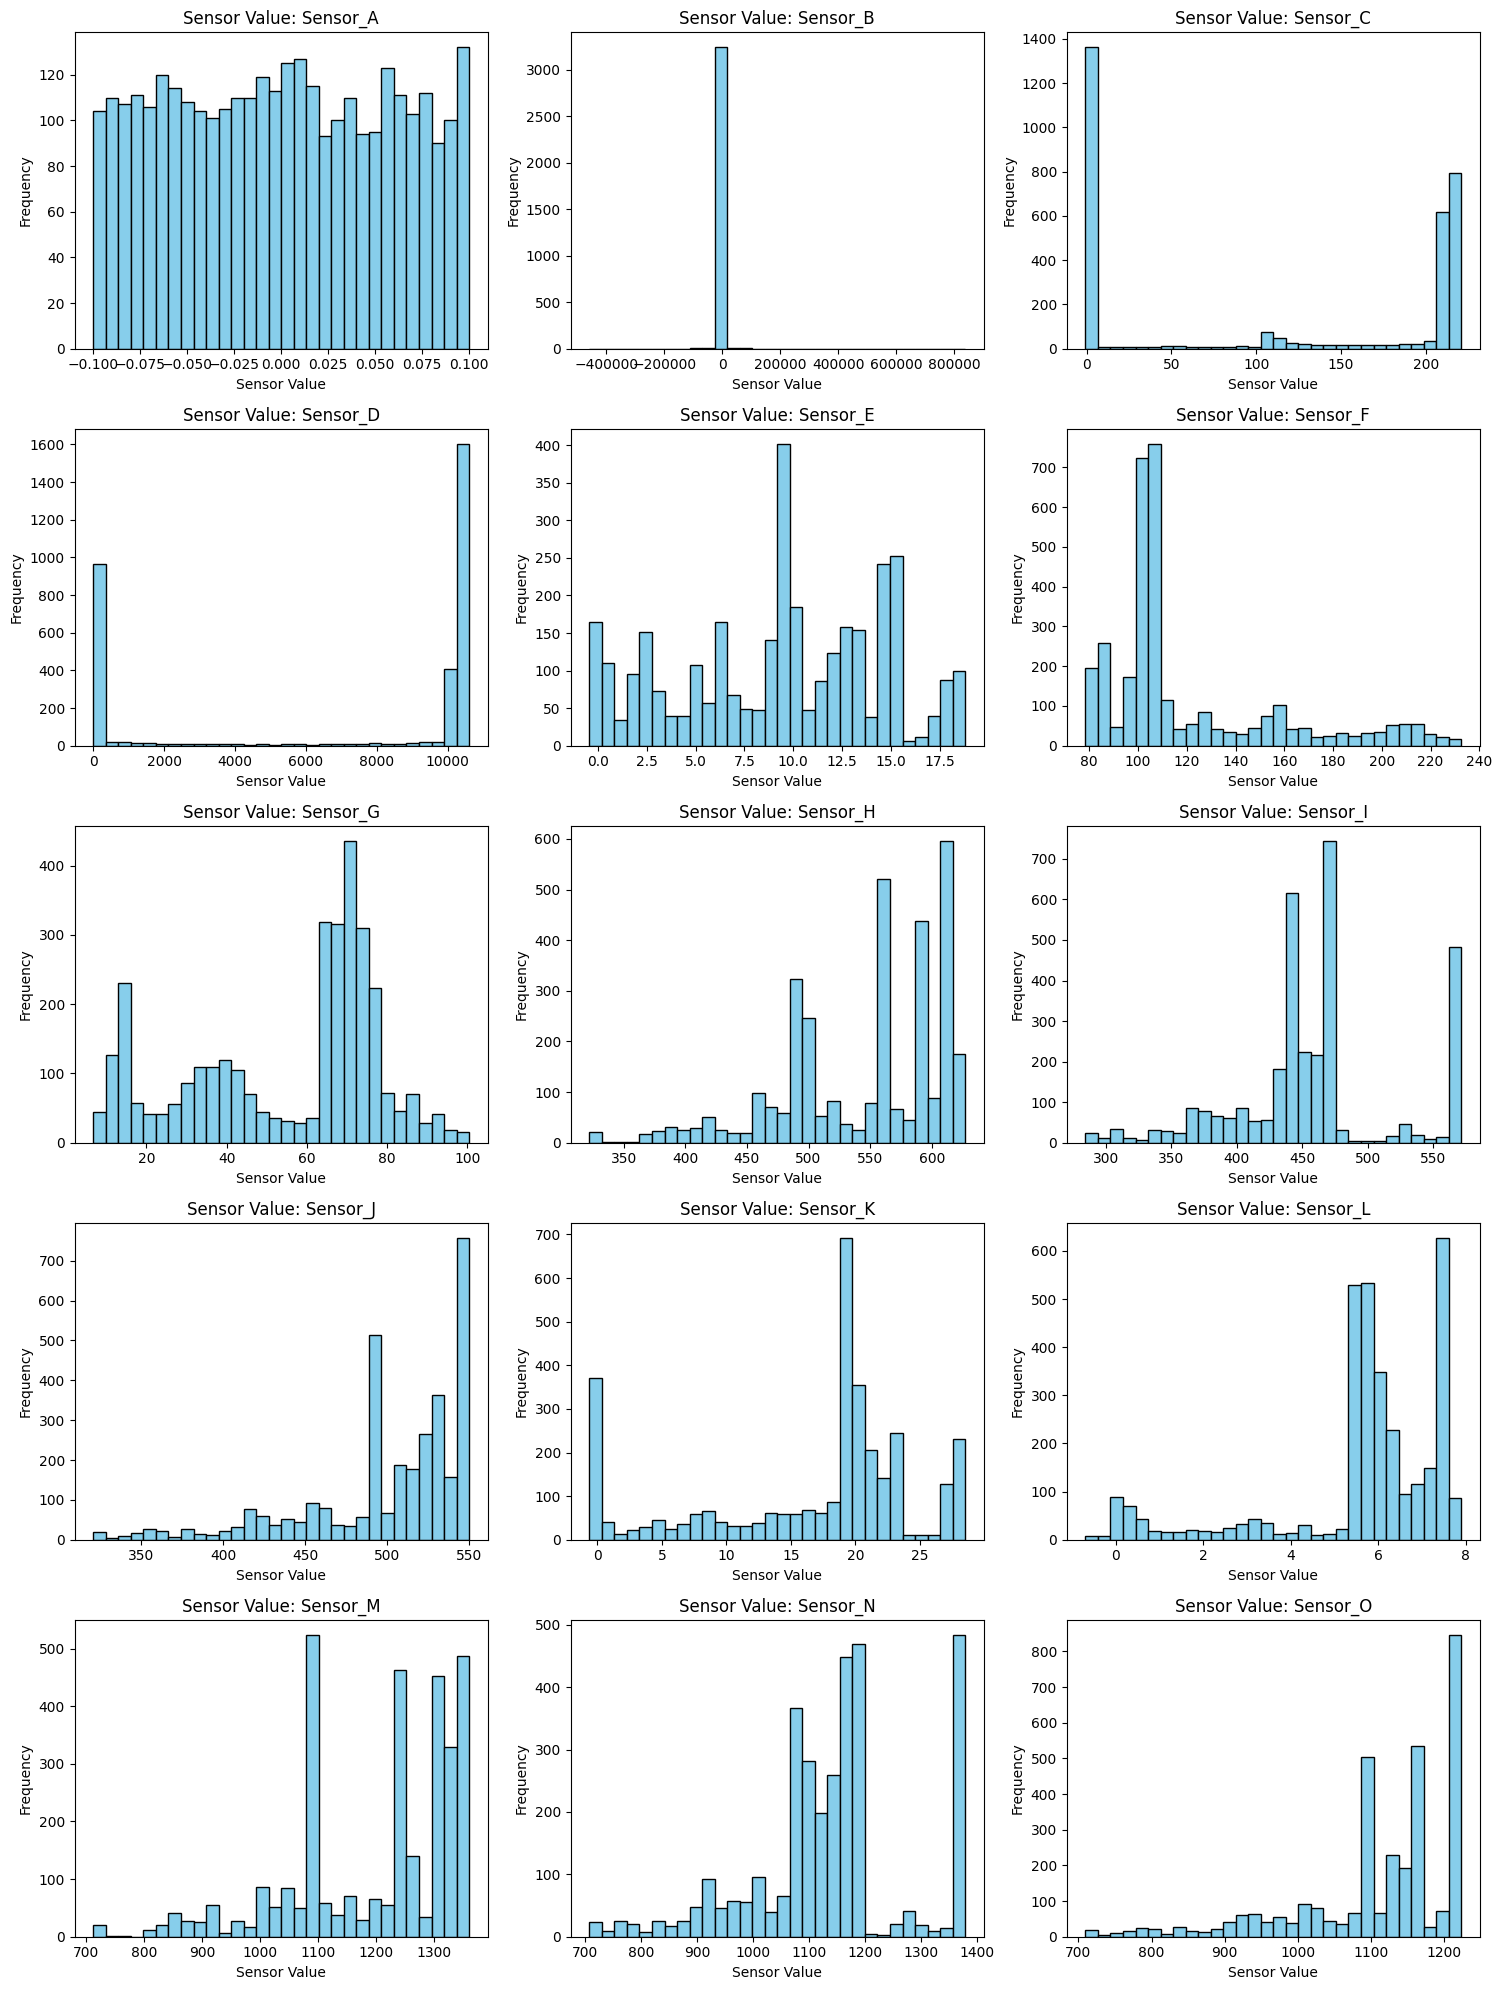

In [15]:

sensor_names = df1['Sensor Name'].unique()
num_sensors = len(sensor_names)

# Set number of rows/cols for subplots
cols = 3
rows = -(-num_sensors // cols)  # ceiling division

fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
axes = axes.flatten()

for i, sensor in enumerate(sensor_names):
    subset = df1[df1['Sensor Name'] == sensor]
    axes[i].hist(subset['Sensor Value'], bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(f"Sensor Value: {sensor}")
    axes[i].set_xlabel("Sensor Value")
    axes[i].set_ylabel("Frequency")

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

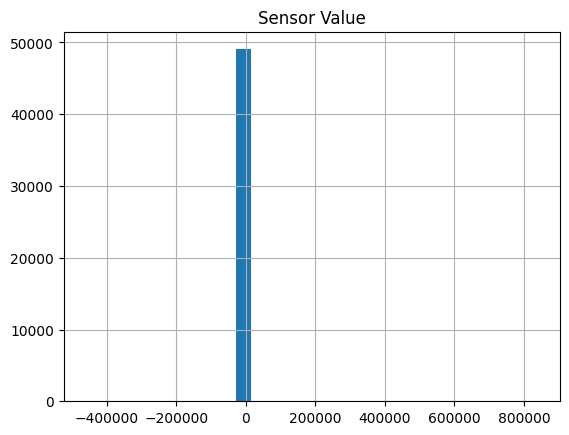

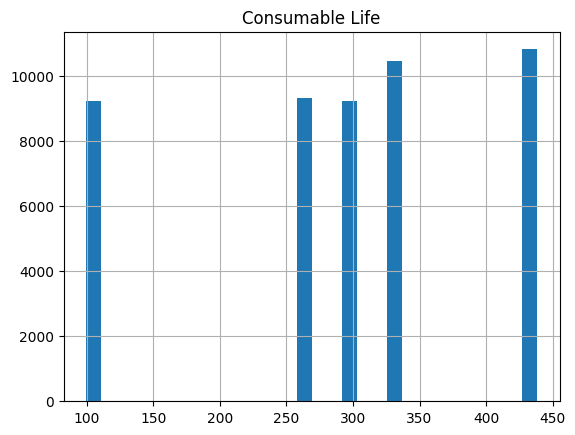

In [16]:
# Distribution plot for Sensor value and Consumable life

filtered_df['Sensor Value'].hist(bins=30, label='Sensor Value')
plt.title('Sensor Value')
plt.show()

filtered_df['Consumable Life'].hist(bins=30, label='Consumable Life')
plt.title('Consumable Life')
plt.show()

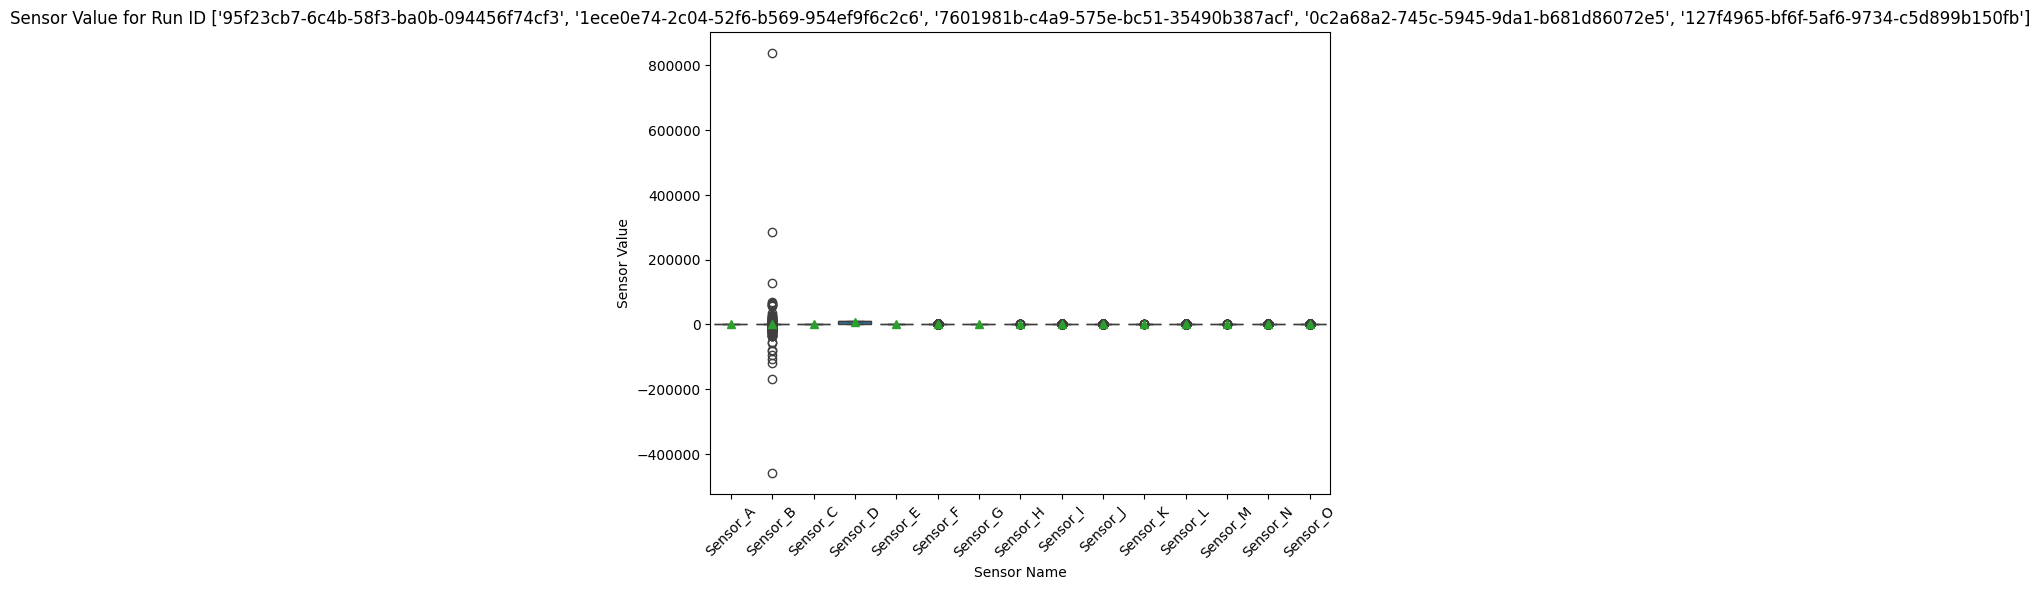

   Sensor Name         mean            min            max           std
0     Sensor_A    -0.000153      -0.099935       0.099983      0.057618
1     Sensor_B    52.063126 -458738.968750  838073.312500  18713.277922
2     Sensor_C   111.500450      -0.739424     220.950760    101.109785
3     Sensor_D  6817.248047      -0.740637   10605.490234   4744.596476
4     Sensor_E     9.353389      -0.442791      18.809427      5.176891
5     Sensor_F   120.254524      78.436981     232.592361     36.885291
6     Sensor_G    55.165916       6.786158     100.424919     23.655577
7     Sensor_H   545.741577     322.264954     627.015137     65.917197
8     Sensor_I   458.101196     284.540039     571.459961     61.677594
9     Sensor_J   501.070068     320.732178     550.251709     48.977445
10    Sensor_K    16.569130      -0.628805      28.514032      8.361335
11    Sensor_L     5.625393      -0.688674       7.896013      1.959215
12    Sensor_M  1200.335938     712.421143    1361.059570    140

In [17]:
# Plot the graph
plt.figure(figsize=(8, 6))  # Adjust figure size
sns.boxplot(x='Sensor Name', y='Sensor Value', data=filtered_df, showmeans=True)
plt.xticks(rotation=45)
plt.title(f'Sensor Value for Run ID {random_run_ids}')

# Show the plot
plt.show()

grouped_df = filtered_df.groupby("Sensor Name")["Sensor Value"].agg(
    mean='mean',
    min='min',
    max='max',
    std='std'
).reset_index()

print(grouped_df)

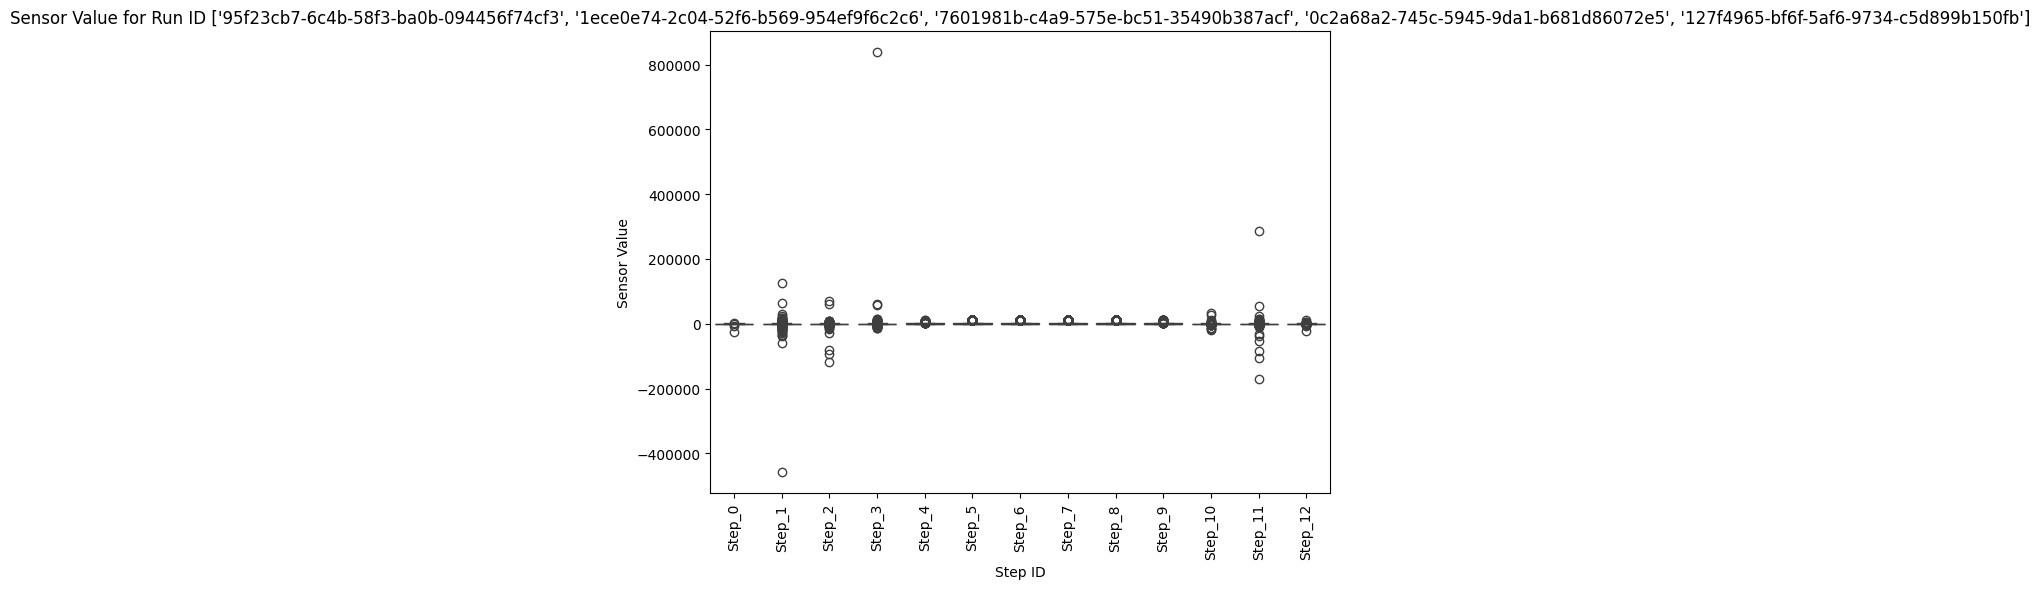

    Step ID         mean            min            max           std
0    Step_0   105.335175  -26415.822266    3760.757568   2080.096191
1    Step_1   170.545517 -458738.968750  127425.343750   7964.393555
2   Step_10   343.836700  -19644.255859   34280.085938   1865.967529
3   Step_11   295.986115 -169436.531250  285896.593750   8412.509766
4   Step_12   246.001740  -22026.564453   10401.660156    767.925842
5    Step_2   223.212265 -118882.179688   69482.445312   4549.398438
6    Step_3   685.519531  -13174.441406  838073.312500  15559.957031
7    Step_4   704.036194      -0.564027   10203.741211   1484.565308
8    Step_5  1058.057739      -0.739424   10605.490234   2526.184570
9    Step_6  1058.046997      -0.698491   10605.484375   2526.532959
10   Step_7  1057.002197      -0.735025   10605.485352   2527.062988
11   Step_8  1055.461548      -0.691767   10605.482422   2527.480469
12   Step_9   702.330505      -0.613489   10394.009766   1654.923950


In [18]:
# Plot the graph
plt.figure(figsize=(8, 6))  # Adjust figure size
sns.boxplot(x='Step ID', y='Sensor Value', data=filtered_df)
plt.xticks(rotation=90)
plt.title(f'Sensor Value for Run ID {random_run_ids}')

# Show the plot
plt.show()

grouped_df = filtered_df.groupby("Step ID")["Sensor Value"].agg(
    mean='mean',
    min='min',
    max='max',
    std='std'
).reset_index()

print(grouped_df)

In [34]:
df_con = filtered_df.groupby('Run ID')['Consumable Life'].mean().reset_index()
print(df_con)

                                 Run ID  Consumable Life
0  0c2a68a2-745c-5945-9da1-b681d86072e5       265.380310
1  127f4965-bf6f-5af6-9734-c5d899b150fb       299.845795
2  1ece0e74-2c04-52f6-b569-954ef9f6c2c6        99.675385
3  7601981b-c4a9-575e-bc51-35490b387acf       329.853760
4  95f23cb7-6c4b-58f3-ba0b-094456f74cf3       438.252441


In [35]:
df_con = filtered_df.groupby('Run ID')['Time Stamp'].mean().reset_index()
print(df_con)

                                 Run ID              Time Stamp
0  0c2a68a2-745c-5945-9da1-b681d86072e5 2024-01-04 03:50:40.000
1  127f4965-bf6f-5af6-9734-c5d899b150fb 2024-01-03 10:48:32.500
2  1ece0e74-2c04-52f6-b569-954ef9f6c2c6 2024-01-02 15:08:12.500
3  7601981b-c4a9-575e-bc51-35490b387acf 2024-01-03 12:34:43.500
4  95f23cb7-6c4b-58f3-ba0b-094456f74cf3 2024-01-01 02:26:40.000


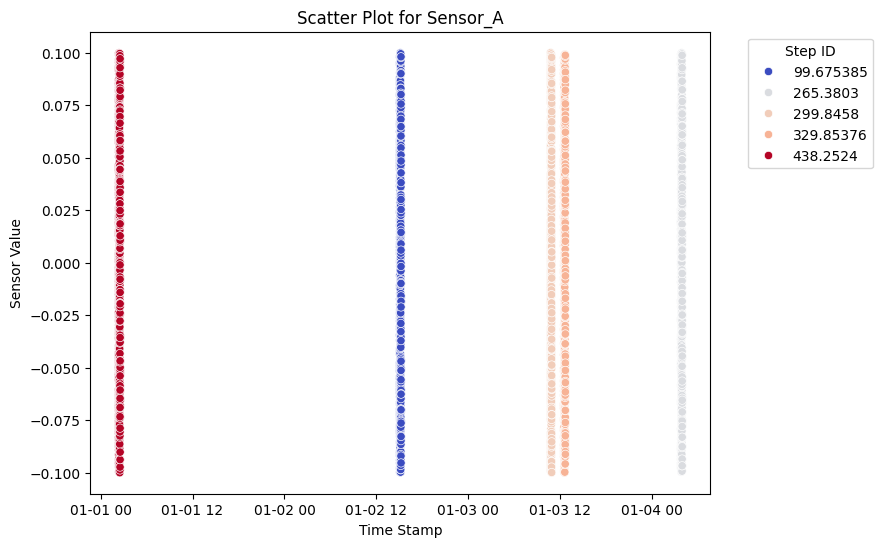

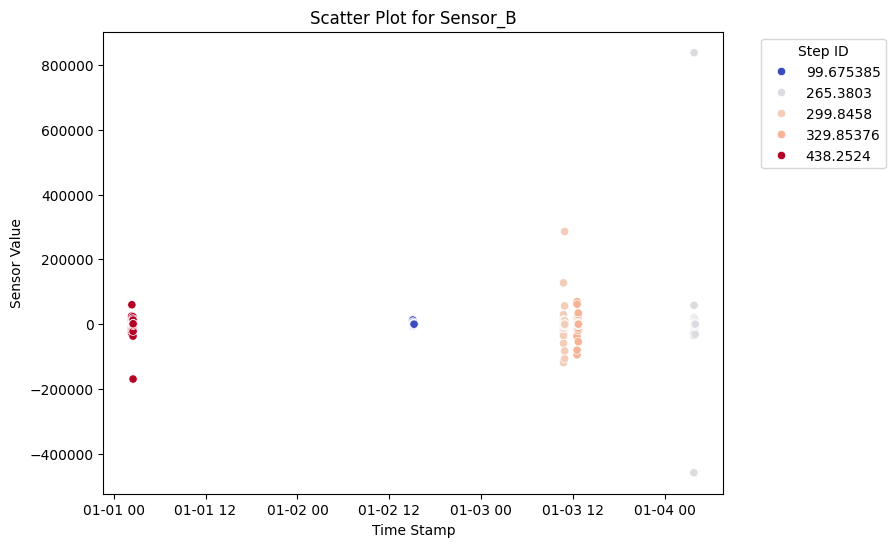

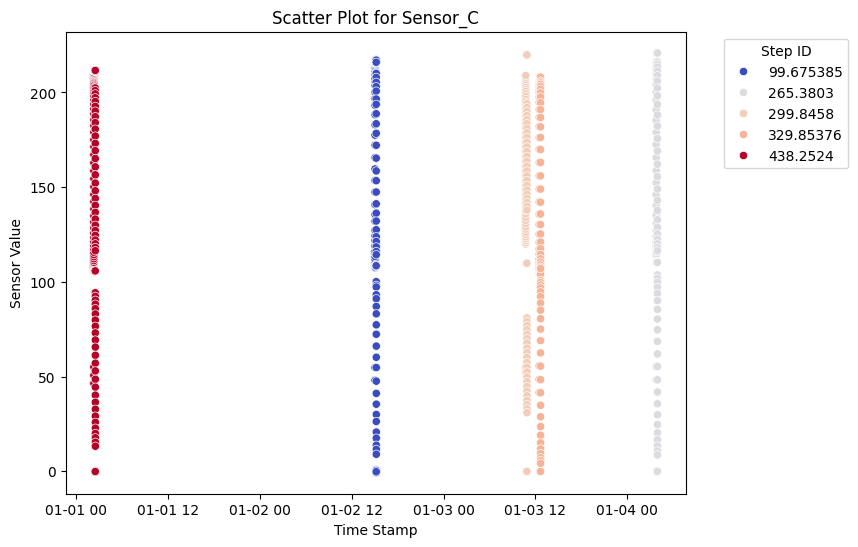

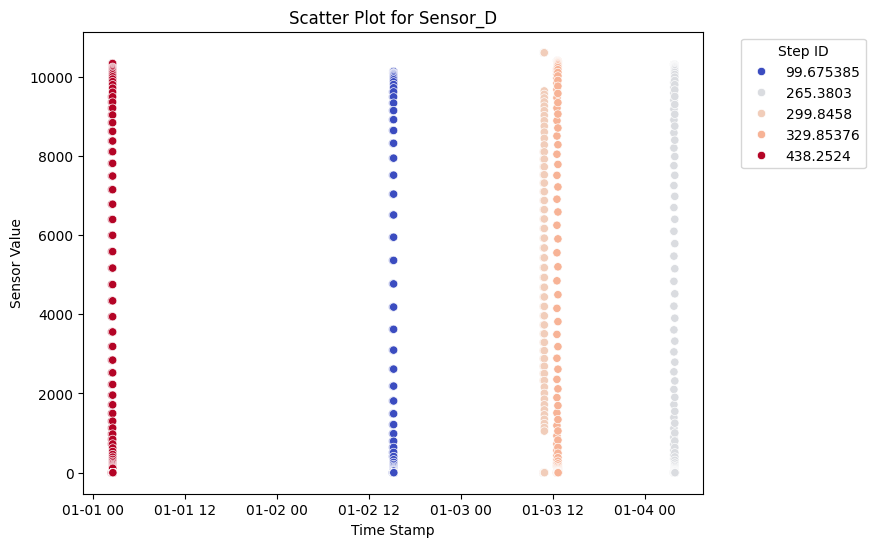

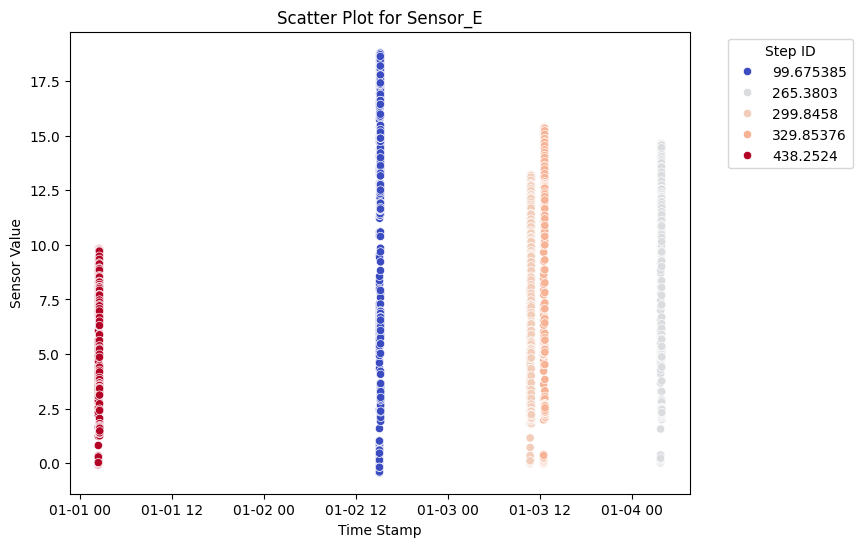

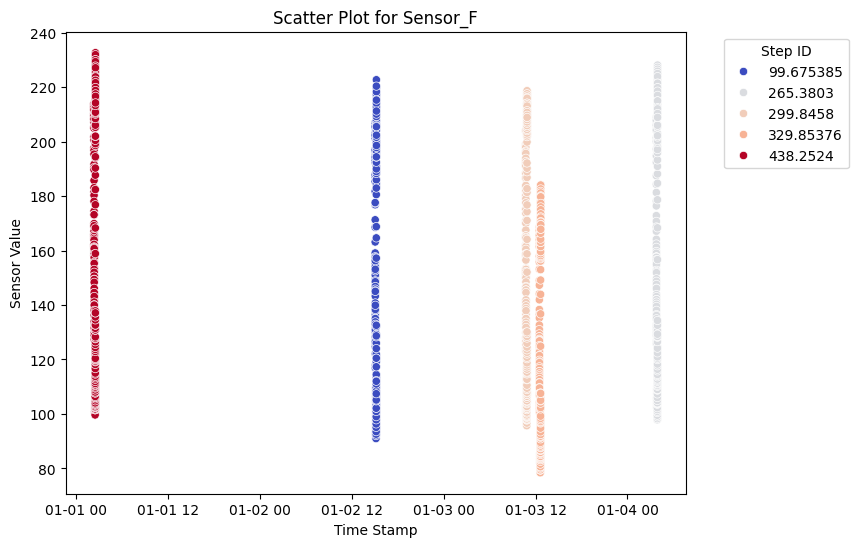

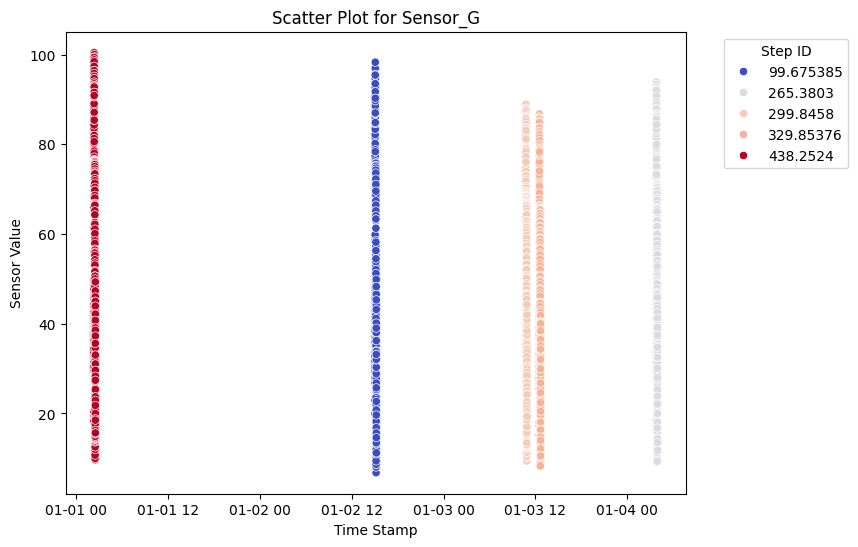

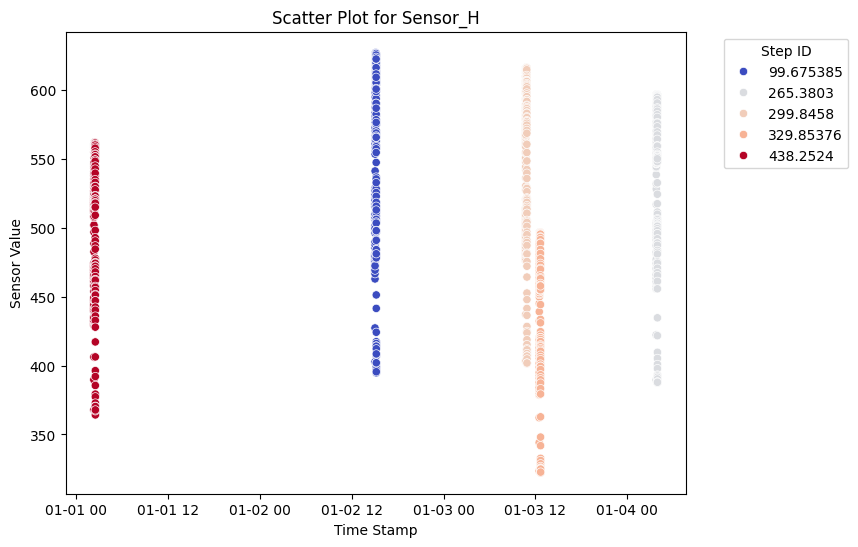

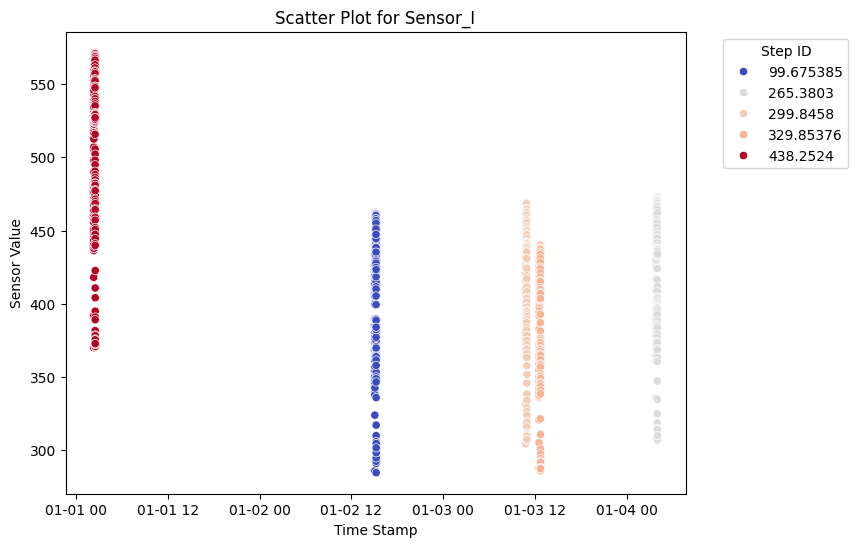

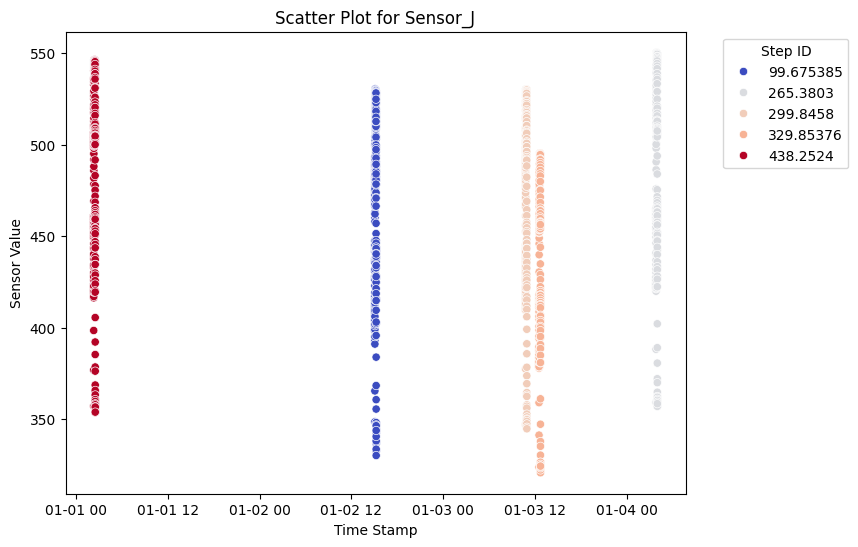

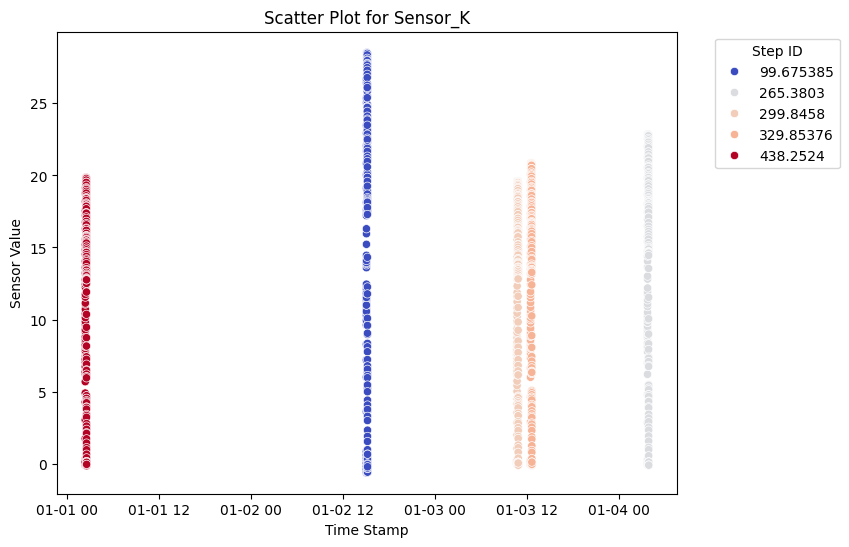

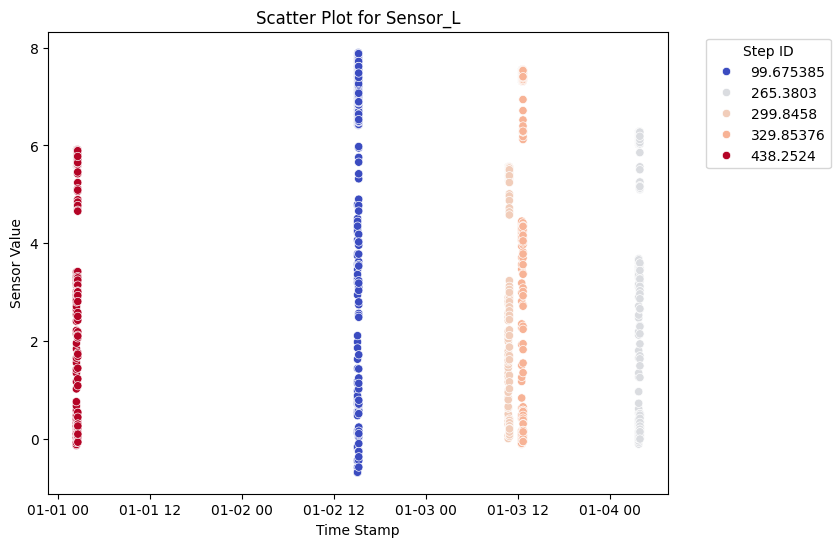

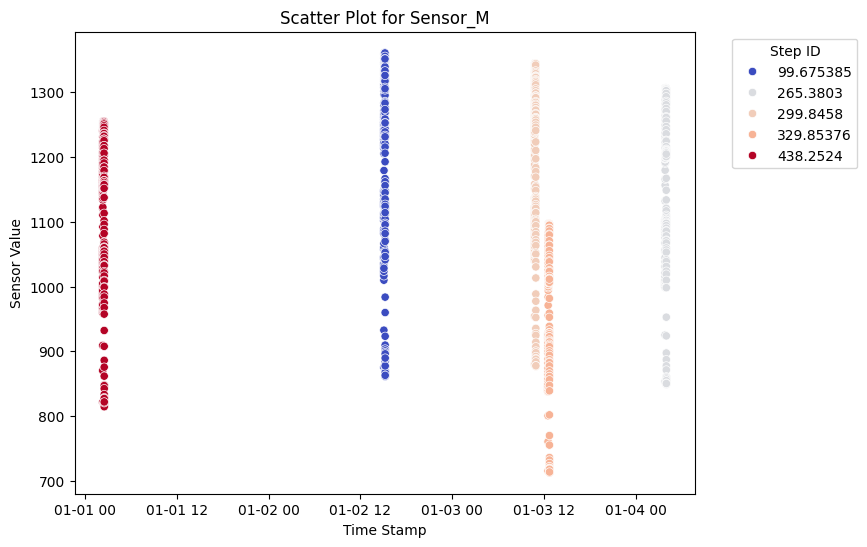

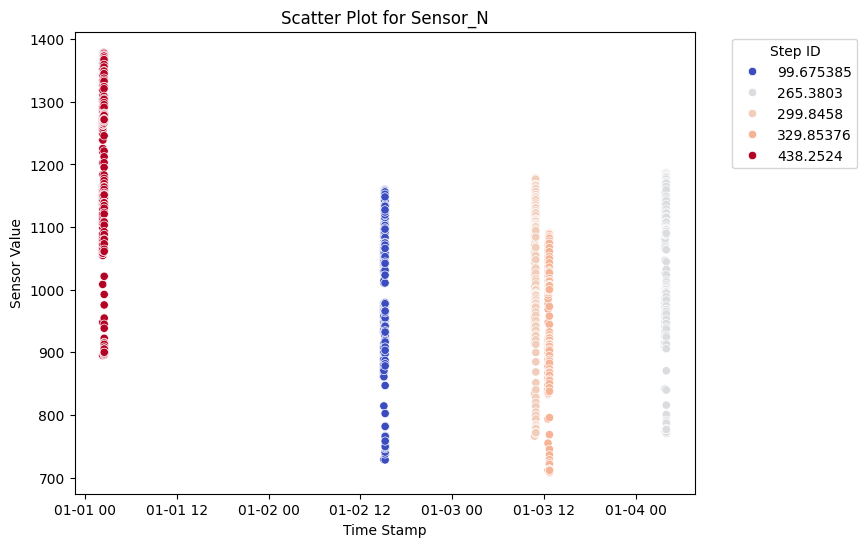

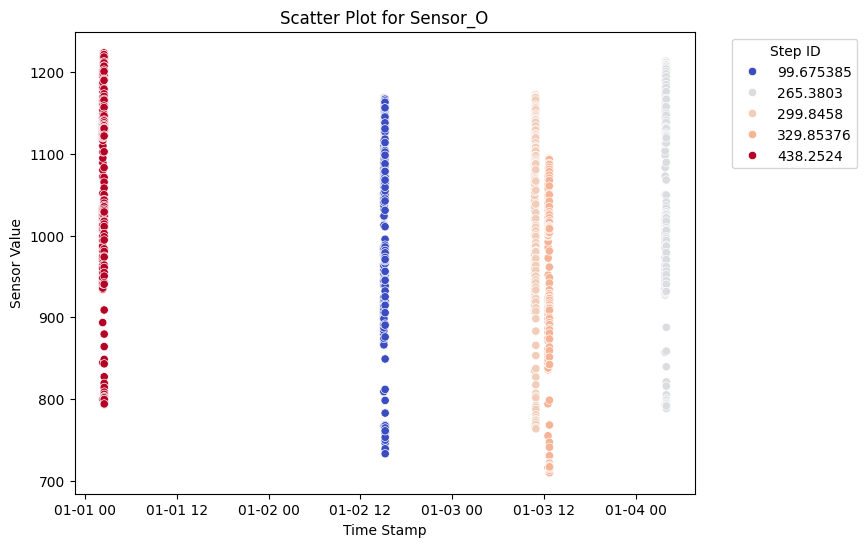

In [37]:
for sensor in filtered_df['Sensor Name'].unique():
    subset_df = filtered_df[filtered_df['Sensor Name'] == sensor]  # Filter data for each Run ID
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='Time Stamp', y='Sensor Value', hue='Consumable Life', palette='coolwarm', data=subset_df)
    plt.legend(title="Step ID", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f"Scatter Plot for {sensor}")
    plt.show()

# unique_sensors = filtered_df['Sensor Name'].unique()
# num_sensors = len(unique_sensors)

# # Set up subplot grid size (e.g., 2 columns)
# cols = 2
# rows = math.ceil(num_sensors / cols)

# # Create subplots
# fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 3), sharex=False, sharey=False)
# axes = axes.flatten()  # Flatten in case of single row or column

# for i, sensor in enumerate(unique_sensors):
#     subset_df = filtered_df[filtered_df['Sensor Name'] == sensor]
    
#     sns.scatterplot(ax=axes[i], x='Time Stamp', y='Sensor Value',
#                     hue='Step ID', palette='coolwarm', data=subset_df, legend=True)
    
#     axes[i].legend(loc='best', bbox_to_anchor=(1, 1.5), fontsize='x-small', title='Step ID', title_fontsize='x-small')
#     axes[i].set_title(f"Scatter Plot for {sensor}", fontsize=10)
#     axes[i].tick_params(axis='x', rotation=45, labelsize=8)

# # Optional: Remove unused subplots
# for j in range(i+1, len(axes)):
#     fig.delaxes(axes[j])

# plt.tight_layout()
# plt.show()

In [50]:
# # 1. Filter by IQR
# # Compute IQR for each Sensor Name group
# def filter_iqr(group):
#     Q1 = group['Sensor Value'].quantile(0.25)
#     Q3 = group['Sensor Value'].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     return group[(group['Sensor Value'] >= lower_bound) & (group['Sensor Value'] <= upper_bound)]

# # Apply IQR filtering per sensor group
# new_df = filtered_df.groupby('Sensor Name', group_keys=False).apply(filter_iqr)

# print('before removing outliers:', len(filtered_df))
# print('after removing outliers:',len(new_df))
# print('outliers:', len(filtered_df)-len(new_df))


# 2. Filter by Z-score
# Compute Z-score per sensor group
filtered_df['Z-score'] = filtered_df.groupby('Sensor Name')['Sensor Value'].transform(lambda x: (x - x.mean()) / x.std())

# Filter outliers (absolute Z-score above threshold, e.g., 3)
new_df = filtered_df[abs(filtered_df['Z-score']) < 3]

print('before removing outliers:', len(filtered_df))
print('after removing outliers:',len(new_df))
print('outliers:', len(filtered_df)-len(new_df))

before removing outliers: 10665
after removing outliers: 10487
outliers: 178


C:\Users\felic\AppData\Local\Temp\ipykernel_2820\1755972448.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Z-score'] = filtered_df.groupby('Sensor Name')['Sensor Value'].transform(lambda x: (x - x.mean()) / x.std())


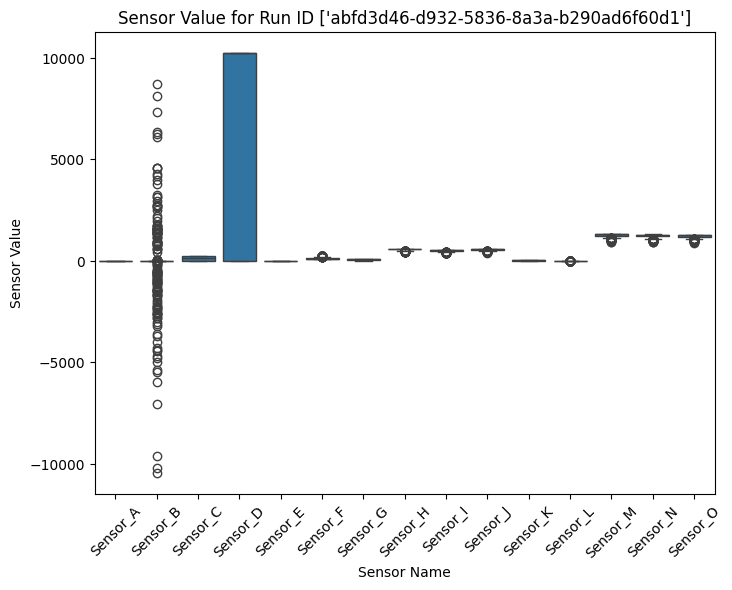

In [51]:
# Plot the graph
plt.figure(figsize=(8, 6))  # Adjust figure size
sns.boxplot(x='Sensor Name', y='Sensor Value', data=new_df)
plt.xticks(rotation=45)
plt.title(f'Sensor Value for Run ID {random_run_ids}')

# Show the plot
plt.show()

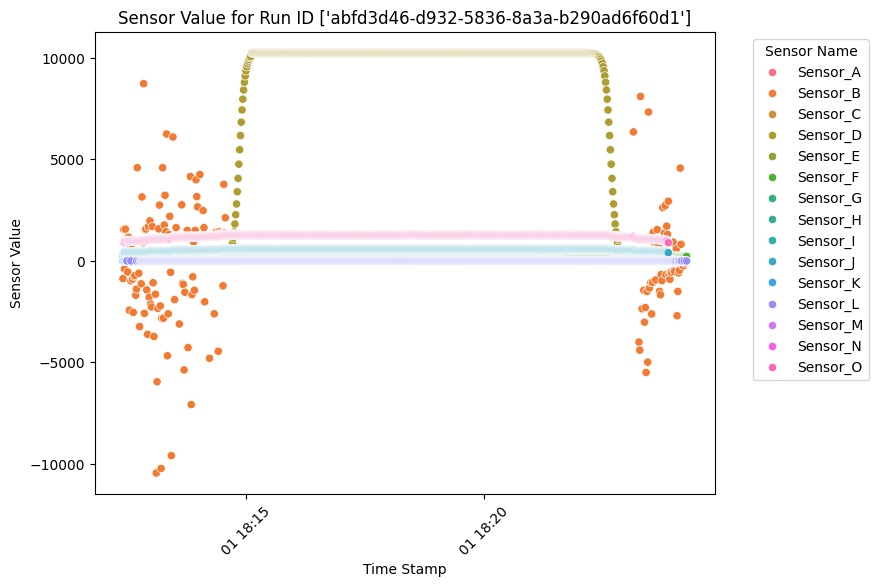

In [52]:
# Plot the graph with categorization
plt.figure(figsize=(8, 6))  # Adjust figure size
sns.scatterplot(x='Time Stamp', y='Sensor Value', hue='Sensor Name', data=new_df)

plt.title(f'Sensor Value for Run ID {random_run_ids}')
plt.legend(title="Sensor Name", bbox_to_anchor=(1.05, 1), loc='upper left')  # Ensure legend shows sensor categories
plt.xticks(rotation=45)  # Rotate timestamps for readability

# Show the plot
plt.show()


In [32]:
# #filter by Step ID
# #comment out if too long
# for step in new_df['Step ID'].unique():
#     plt.figure(figsize=(8, 6))
#     sns.boxplot(x='Sensor Name', y='Sensor Value', data=new_df[new_df['Step ID'] == step])
#     plt.xticks(rotation=45)
#     plt.title(f'Sensor Value for {step} (Run ID {random_run_ids})')
#     plt.show()

In [45]:
# for step in new_df['Process Step'].unique():
#     plt.figure(figsize=(8, 6))
#     sns.boxplot(x='Sensor Name', y='Sensor Value', data=new_df[new_df['Process Step'] == step])
#     plt.xticks(rotation=45)
#     plt.title(f'Sensor Value for {step} (Run ID {random_run_ids})')
#     plt.show()

In [44]:
print('Number of Run ID:', incom_run_df["Run ID"].nunique())
print('Number of Process Steps:', incom_run_df["Process Step"].nunique())
print('Number of Step ID:', incom_run_df["Step ID"].nunique())
print('Number of Sensor Name:', incom_run_df["Sensor Name"].nunique())

Number of Run ID: 225
Number of Process Steps: 1
Number of Step ID: 8
Number of Sensor Name: 41


In [58]:
# Use Run ID from run_df

print(random_run_ids)
# Filter the DataFrame
filtered_incom_df = incom_run_df[incom_run_df['Run ID'].isin(random_run_ids)]

['abfd3d46-d932-5836-8a3a-b290ad6f60d1']


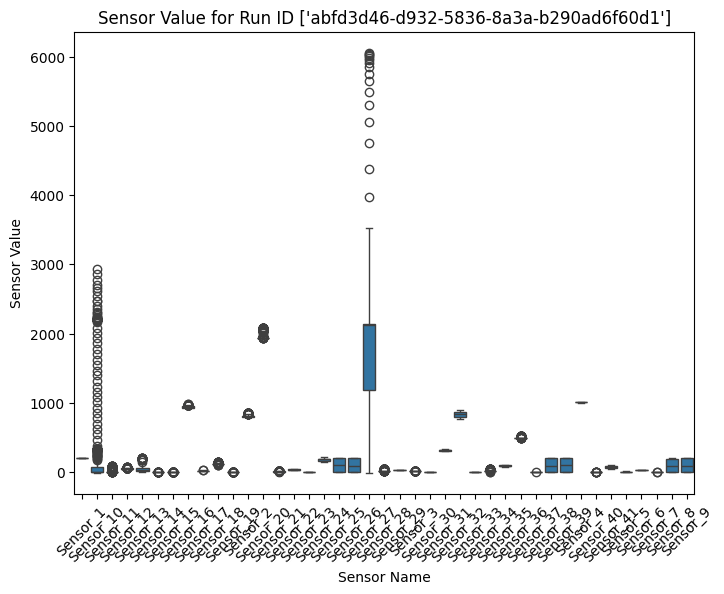

   Sensor Name         mean          min          max         std
0     Sensor_1   205.261398   205.261398   205.261398    0.000000
1    Sensor_10   310.245178   -10.154788  2928.842773  716.993530
2    Sensor_11     5.344971    -1.388979    89.674423   15.270065
3    Sensor_12    53.010948    49.290493    67.268349    5.386009
4    Sensor_13    48.460068     8.345216   197.092255   45.466942
5    Sensor_14     0.614861     0.354572     1.138578    0.203519
6    Sensor_15     5.198719     4.594263     8.122078    0.757694
7    Sensor_16   942.630615   931.058899   977.587585   14.248927
8    Sensor_17    18.504023    14.564845    29.093561    3.274477
9    Sensor_18   121.120934    98.976685   147.406494    6.458738
10   Sensor_19     0.142302    -0.087814     0.600141    0.126202
11    Sensor_2   812.619385   802.305298   851.116577   15.899867
12   Sensor_20  1955.001587  1932.991333  2078.029785   44.470490
13   Sensor_21     9.133909     4.951620    16.299677    2.793998
14   Senso

In [66]:
# Plot the graph
plt.figure(figsize=(8, 6))  # Adjust figure size
sns.boxplot(x='Sensor Name', y='Sensor Value', data=filtered_incom_df)
plt.xticks(rotation=45)
plt.title(f'Sensor Value for Run ID {random_run_ids}')

# Show the plot
plt.show()

grouped_df = filtered_incom_df.groupby("Sensor Name")["Sensor Value"].agg(
    mean='mean',
    min='min',
    max='max',
    std='std'
).reset_index()

print(grouped_df)

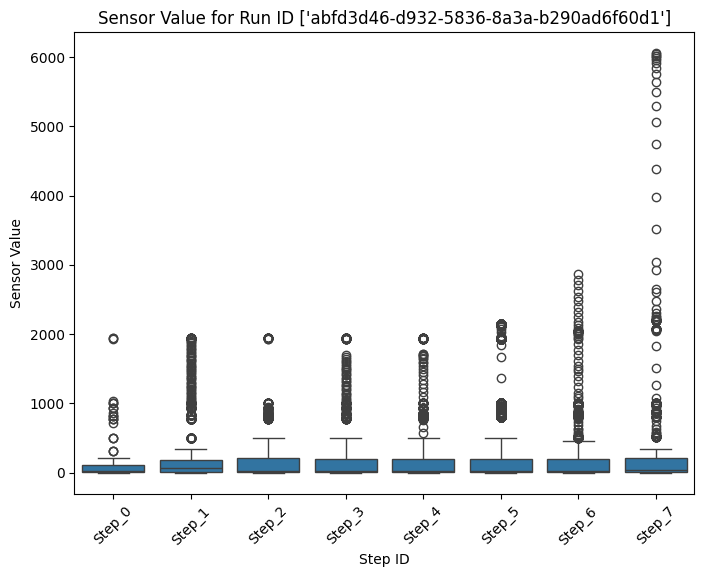

  Step ID        mean        min          max         std
0  Step_0  200.208054  -7.670541  1937.697998  398.697357
1  Step_1  235.729965  -8.011786  1937.604736  424.231018
2  Step_2  216.960464  -2.601560  1949.429077  395.578583
3  Step_3  222.857407  -5.154065  1949.822021  417.148163
4  Step_4  220.917847 -10.154788  1937.355835  417.494354
5  Step_5  244.187576 -10.150772  2151.718994  485.372192
6  Step_6  239.299500  -2.009425  2865.682617  465.420868
7  Step_7  330.719696  -1.813590  6055.980957  769.409851


In [65]:
# Plot the graph
plt.figure(figsize=(8, 6))  # Adjust figure size
sns.boxplot(x='Step ID', y='Sensor Value', data=filtered_incom_df)
plt.xticks(rotation=45)
plt.title(f'Sensor Value for Run ID {random_run_ids}')

# Show the plot
plt.show()

grouped_df = filtered_incom_df.groupby("Step ID")["Sensor Value"].agg(
    mean='mean',
    min='min',
    max='max',
    std='std'
).reset_index()

print(grouped_df)

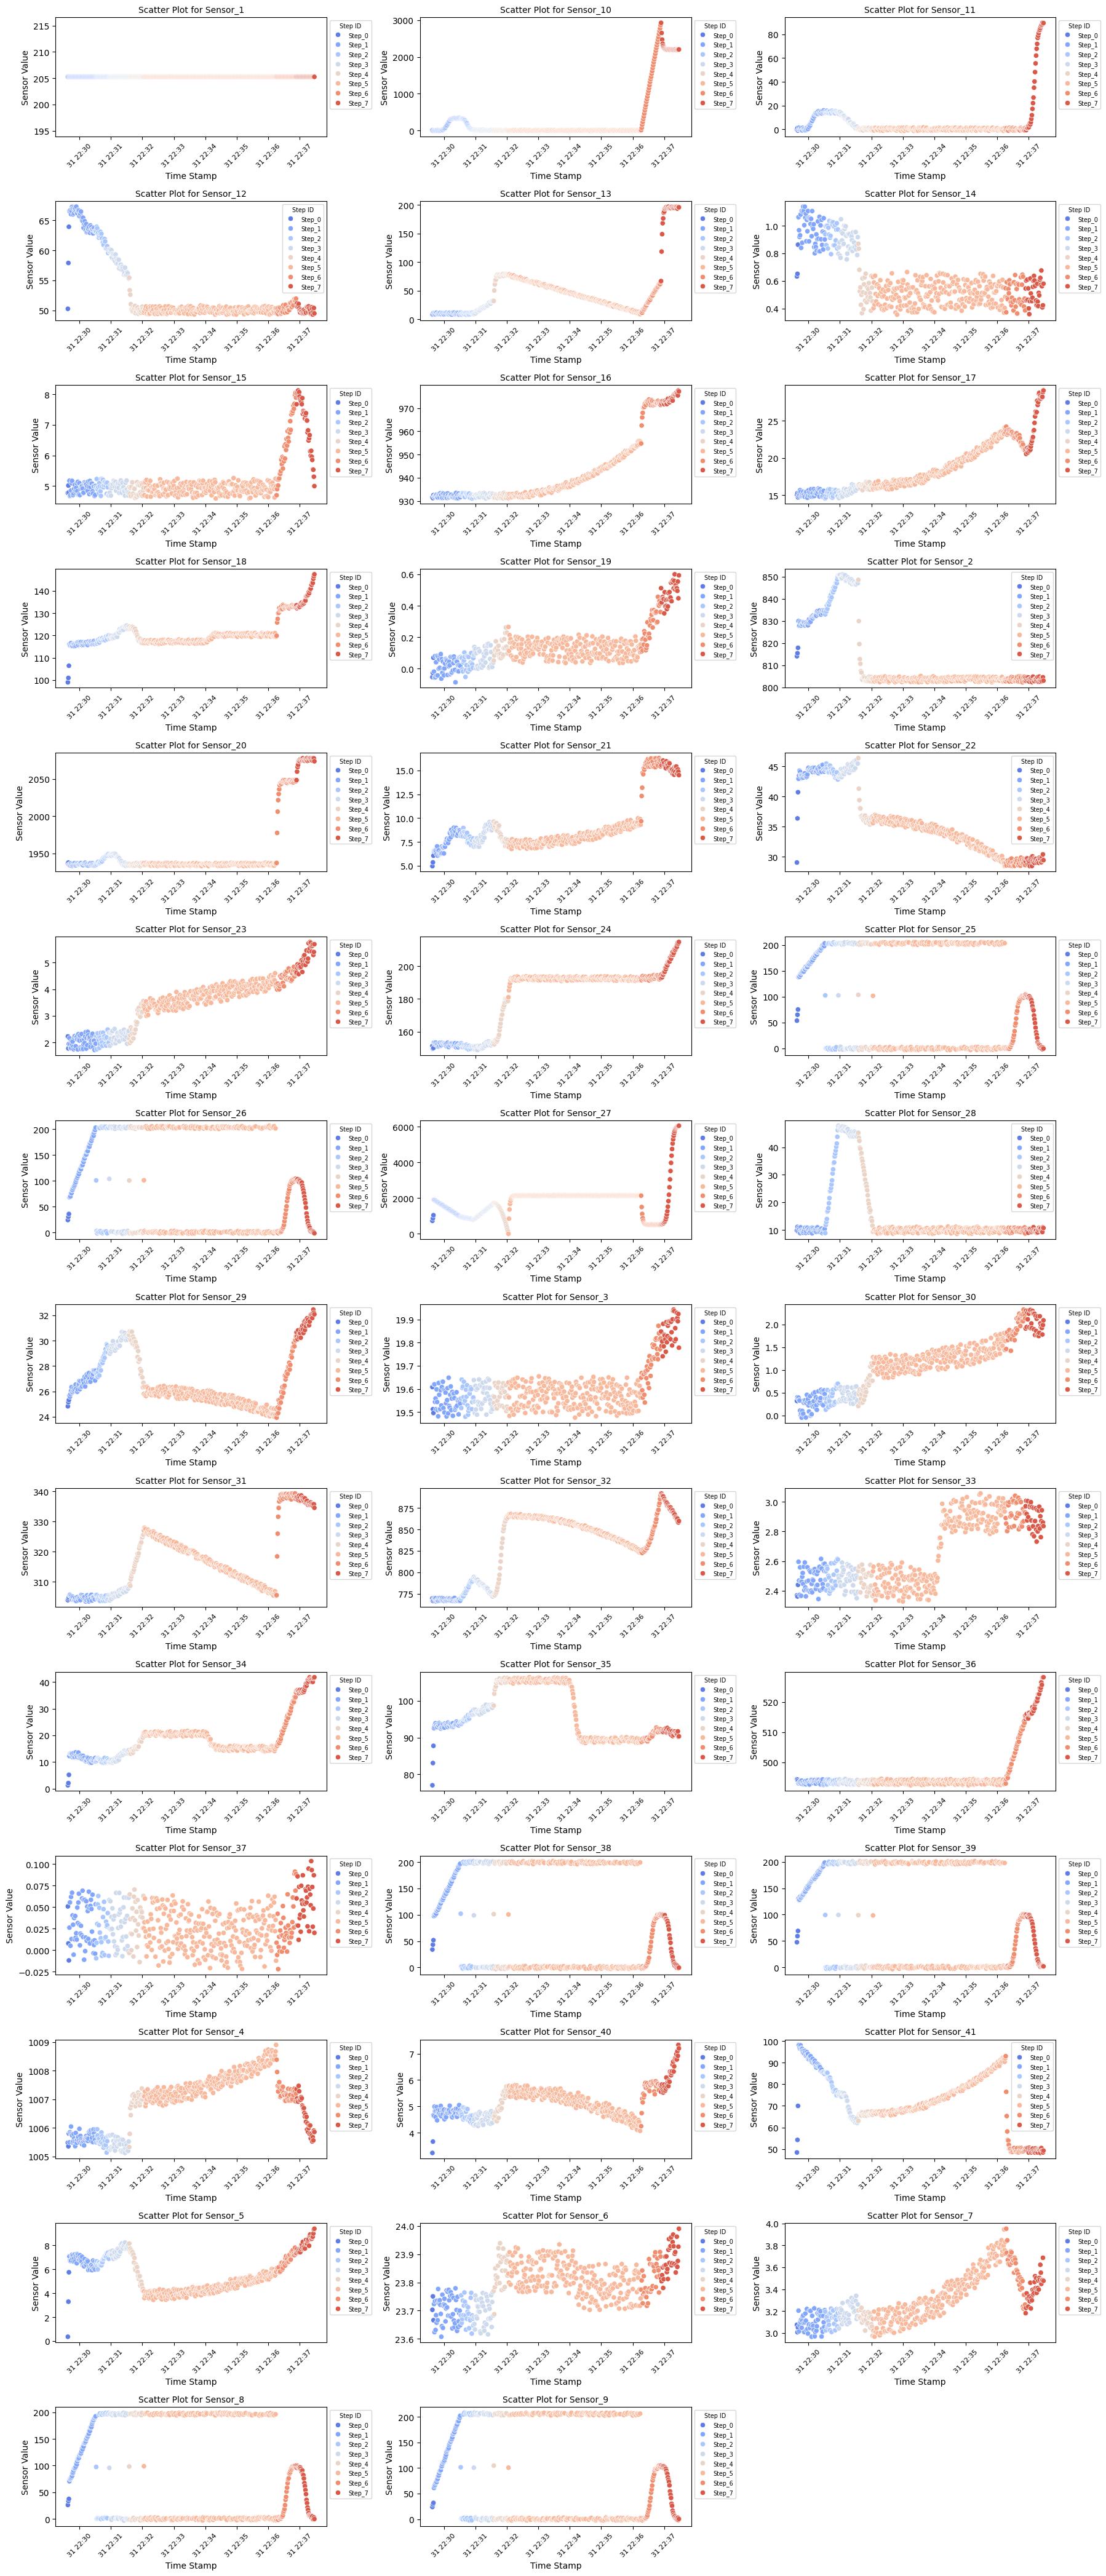

In [61]:
# for sensor in filtered_incom_df['Sensor Name'].unique():
#     subset_df = filtered_incom_df[filtered_incom_df['Sensor Name'] == sensor]  # Filter data for each Run ID
    
#     plt.figure(figsize=(8, 6))
#     sns.scatterplot(x='Time Stamp', y='Sensor Value', hue='Step ID', palette='coolwarm', data=subset_df)
#     plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.title(f"Scatter Plot for {sensor}")
#     plt.show()

unique_sensors = filtered_incom_df['Sensor Name'].unique()
num_sensors = len(unique_sensors)

# Set up subplot grid size (e.g., 2 columns)
cols = 3
rows = math.ceil(num_sensors / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 3), sharex=False, sharey=False)
axes = axes.flatten()  # Flatten in case of single row or column

for i, sensor in enumerate(unique_sensors):
    subset_df = filtered_incom_df[filtered_incom_df['Sensor Name'] == sensor]
    
    sns.scatterplot(ax=axes[i], x='Time Stamp', y='Sensor Value',
                    hue='Step ID', palette='coolwarm', data=subset_df, legend=True)
    
    axes[i].legend(loc='best', bbox_to_anchor=(1, 1), fontsize='x-small', title='Step ID', title_fontsize='x-small')
    axes[i].set_title(f"Scatter Plot for {sensor}", fontsize=10)
    axes[i].tick_params(axis='x', rotation=45, labelsize=8)

# Optional: Remove unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

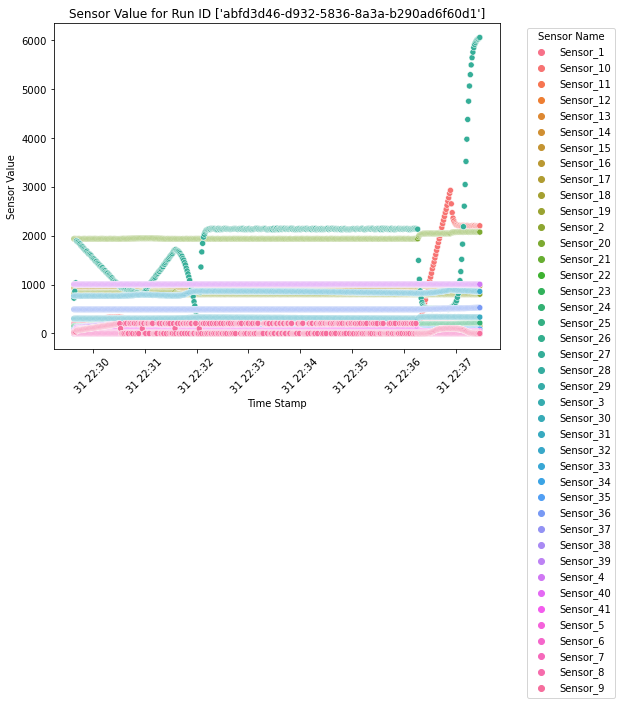

In [49]:
# Plot the graph with categorization
plt.figure(figsize=(8, 6))  # Adjust figure size
sns.scatterplot(x='Time Stamp', y='Sensor Value', hue='Sensor Name', data=filtered_incom_df)

plt.title(f'Sensor Value for Run ID {random_run_ids}')
plt.legend(title="Sensor Name", bbox_to_anchor=(1.05, 1), loc='upper left')  # Ensure legend shows sensor categories
plt.xticks(rotation=45)  # Rotate timestamps for readability

# Show the plot
plt.show()


In [68]:
# Pivot the DataFrames
run_pivot = filtered_df.pivot(index='Time Stamp', columns='Sensor Name', values='Sensor Value', )
run_pivot = run_pivot.reset_index()

incoming_pivot = filtered_incom_df.pivot(index='Time Stamp', columns='Sensor Name', values='Sensor Value')
incoming_pivot = incoming_pivot.reset_index()

# Drop timestamps and concat both dataframes
run_pivot = run_pivot.drop('Time Stamp', axis=1)
incoming_pivot = incoming_pivot.drop('Time Stamp', axis=1)
combined_df = pd.concat([run_pivot, incoming_pivot], axis=1)

# Compute correlations
corr_matrix = combined_df.corr()


In [76]:
import plotly.express as px

fig = px.imshow(corr_matrix.astype(float), 
                text_auto='.2f', 
                color_continuous_scale='RdBu_r', 
                aspect='auto')
fig.update_layout(width=1000, height=1000)
# fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'coloraxis': 'coloraxis',
              'hovertemplate': 'Sensor Name: %{x}<br>Sensor Name: %{y}<br>color: %{z}<extra></extra>',
              'name': '0',
              'texttemplate': '%{z:.2f}',
              'type': 'heatmap',
              'x': array(['Sensor_A', 'Sensor_B', 'Sensor_C', 'Sensor_D', 'Sensor_E', 'Sensor_F',
                          'Sensor_G', 'Sensor_H', 'Sensor_I', 'Sensor_J', 'Sensor_K', 'Sensor_L',
                          'Sensor_M', 'Sensor_N', 'Sensor_O', 'Sensor_1', 'Sensor_10',
                          'Sensor_11', 'Sensor_12', 'Sensor_13', 'Sensor_14', 'Sensor_15',
                          'Sensor_16', 'Sensor_17', 'Sensor_18', 'Sensor_19', 'Sensor_2',
                          'Sensor_20', 'Sensor_21', 'Sensor_22', 'Sensor_23', 'Sensor_24',
                          'Sensor_25', 'Sensor_26', 'Sensor_27', 'Sensor_28', 'Sensor_29',
                          'Sensor_3', 'Sensor_30', 'Sensor_31', 'Sensor_32', 'Sensor_33',
                          'Sensor_34', 'Sensor_35', 'Sensor_36', 'Sensor_37', 'Sensor_38',
                          'Sensor_39', 'Sensor_4', 'Sensor_40', 'Sensor_41', 'Sensor_5',
                          'Sensor_6', 'Sensor_7', 'Sensor_8', 'Sensor_9'], dtype=object),
              'xaxis': 'x',
              'y': array(['Sensor_A', 'Sensor_B', 'Sensor_C', 'Sensor_D', 'Sensor_E', 'Sensor_F',
                          'Sensor_G', 'Sensor_H', 'Sensor_I', 'Sensor_J', 'Sensor_K', 'Sensor_L',
                          'Sensor_M', 'Sensor_N', 'Sensor_O', 'Sensor_1', 'Sensor_10',
                          'Sensor_11', 'Sensor_12', 'Sensor_13', 'Sensor_14', 'Sensor_15',
                          'Sensor_16', 'Sensor_17', 'Sensor_18', 'Sensor_19', 'Sensor_2',
                          'Sensor_20', 'Sensor_21', 'Sensor_22', 'Sensor_23', 'Sensor_24',
                          'Sensor_25', 'Sensor_26', 'Sensor_27', 'Sensor_28', 'Sensor_29',
                          'Sensor_3', 'Sensor_30', 'Sensor_31', 'Sensor_32', 'Sensor_33',
                          'Sensor_34', 'Sensor_35', 'Sensor_36', 'Sensor_37', 'Sensor_38',
                          'Sensor_39', 'Sensor_4', 'Sensor_40', 'Sensor_41', 'Sensor_5',
                          'Sensor_6', 'Sensor_7', 'Sensor_8', 'Sensor_9'], dtype=object),
              'yaxis': 'y',
              'z': {'bdata': ('AAAAAAAA8D/G87HQ1XisPycdAU5+33' ... 'm1yKvDvxat+M9O++8/AAAAAAAA8D8='),
                    'dtype': 'f8',
                    'shape': '56, 56'}}],
    'layout': {'coloraxis': {'colorscale': [[0.0, 'rgb(5,48,97)'], [0.1,
                                            'rgb(33,102,172)'], [0.2,
                                            'rgb(67,147,195)'], [0.3,
                                            'rgb(146,197,222)'], [0.4,
                                            'rgb(209,229,240)'], [0.5,
                                            'rgb(247,247,247)'], [0.6,
                                            'rgb(253,219,199)'], [0.7,
                                            'rgb(244,165,130)'], [0.8,
                                            'rgb(214,96,77)'], [0.9,
                                            'rgb(178,24,43)'], [1.0,
                                            'rgb(103,0,31)']]},
               'height': 1000,
               'margin': {'t': 60},
               'template': '...',
               'width': 1000,
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'Sensor Name'}},
               'yaxis': {'anchor': 'x', 'autorange': 'reversed', 'domain': [0.0, 1.0], 'title': {'text': 'Sensor Name'}}}
})

In [186]:
# Step 1: Replace diagonal (self-correlation = 1) with NaN if you want to exclude them
corr_no_diag = corr_matrix.mask(np.eye(len(corr_matrix), dtype=bool))

# Stack to convert matrix into a Series with MultiIndex (row, column)
stacked_corr = corr_no_diag.stack()

# Sort descending by correlation value
sorted_corr = stacked_corr.sort_values(ascending=False)

# Get top 10
top_10 = sorted_corr.head(20)

print(top_10)


Sensor Name  Sensor Name
Sensor_M     Sensor_H       0.999990
Sensor_H     Sensor_M       0.999990
Sensor_O     Sensor_J       0.999989
Sensor_J     Sensor_O       0.999989
Sensor_N     Sensor_I       0.999960
Sensor_I     Sensor_N       0.999960
Sensor_9     Sensor_26      0.999661
Sensor_26    Sensor_9       0.999661
             Sensor_8       0.999650
Sensor_8     Sensor_26      0.999650
Sensor_25    Sensor_39      0.999592
Sensor_39    Sensor_25      0.999592
Sensor_8     Sensor_9       0.999427
Sensor_9     Sensor_8       0.999427
Sensor_N     Sensor_M       0.999086
Sensor_M     Sensor_N       0.999086
Sensor_O     Sensor_M       0.999066
Sensor_M     Sensor_O       0.999066
Sensor_O     Sensor_N       0.999041
Sensor_N     Sensor_O       0.999041
dtype: float64


In [193]:
# If square matrix, ignore diagonal
corr_no_diag = corr_matrix.mask(np.eye(len(corr_matrix), dtype=bool))

# Find sensor pair with max correlation
max_pair = corr_no_diag.stack().idxmax()
sensor_x, sensor_y = max_pair
print(f"Highest correlated sensors: {sensor_x} and {sensor_y}")

Highest correlated sensors: Sensor_H and Sensor_M


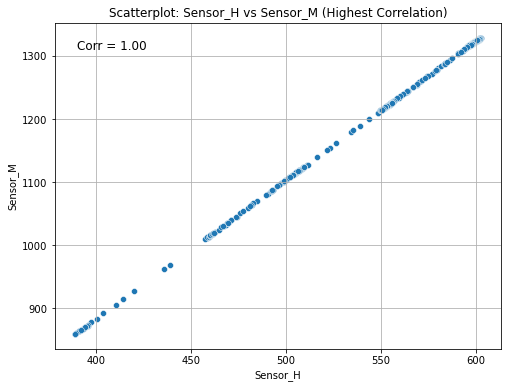

In [195]:
x = run_pivot[sensor_x]
y = run_pivot[sensor_y]

corr_value = corr_matrix.loc[sensor_x, sensor_y]

plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y)
plt.xlabel(sensor_x)
plt.ylabel(sensor_y)
plt.title(f"Scatterplot: {sensor_x} vs {sensor_y} (Highest Correlation)")
plt.grid(True)
plt.text(0.05, 0.95, f"Corr = {corr_value:.2f}", transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top')
plt.show()


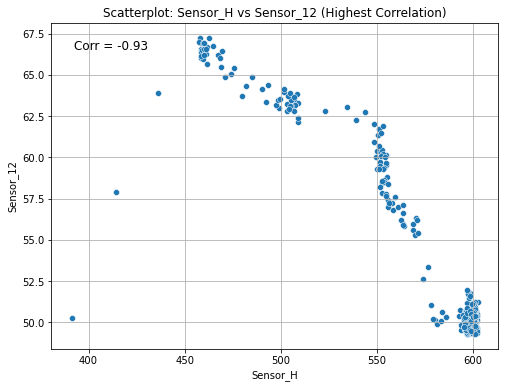

In [202]:
sensor_x, sensor_y = 'Sensor_H', 'Sensor_12'

x = run_pivot[sensor_x]
y = incoming_pivot[sensor_y]

corr_value = corr_matrix.loc[sensor_x, sensor_y]

plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y)
plt.xlabel(sensor_x)
plt.ylabel(sensor_y)
plt.title(f"Scatterplot: {sensor_x} vs {sensor_y} (Highest Correlation)")
plt.grid(True)
plt.text(0.05, 0.95, f"Corr = {corr_value:.2f}", transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top')
plt.show()


In [203]:
filtered_df.loc[:, 'Run type'] = 'current_run'
filtered_incom_df.loc[:, 'Run type'] = 'incoming_run'

C:\Users\felic\AppData\Local\Temp\ipykernel_16756\4197654664.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\felic\AppData\Local\Temp\ipykernel_16756\4197654664.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [204]:
df_combined = pd.concat([filtered_df, filtered_incom_df], ignore_index=True)

In [208]:
df_combined

Tool ID      Run Start Time  \
0      8060e8e1-504a-5138-a9f0-e2770bd61ba1 2024-01-01 18:12:25   
1      8060e8e1-504a-5138-a9f0-e2770bd61ba1 2024-01-01 18:12:25   
2      8060e8e1-504a-5138-a9f0-e2770bd61ba1 2024-01-01 18:12:25   
3      8060e8e1-504a-5138-a9f0-e2770bd61ba1 2024-01-01 18:12:25   
4      8060e8e1-504a-5138-a9f0-e2770bd61ba1 2024-01-01 18:12:25   
...                                     ...                 ...   
29971  8060e8e1-504a-5138-a9f0-e2770bd61ba1 2023-12-31 22:29:38   
29972  8060e8e1-504a-5138-a9f0-e2770bd61ba1 2023-12-31 22:29:38   
29973  8060e8e1-504a-5138-a9f0-e2770bd61ba1 2023-12-31 22:29:38   
29974  8060e8e1-504a-5138-a9f0-e2770bd61ba1 2023-12-31 22:29:38   
29975  8060e8e1-504a-5138-a9f0-e2770bd61ba1 2023-12-31 22:29:38   

             Run End Time                                Run ID  \
0     2024-01-01 18:25:00  abfd3d46-d932-5836-8a3a-b290ad6f60d1   
1     2024-01-01 18:25:00  abfd3d46-d932-5836-8a3a-b290ad6f60d1   
2     2024-01-01 18:25:00  abfd3d46-d932-5836-8a3a-b290ad6f60d1   
3     2024-01-01 18:25:00  abfd3d46-d932-5836-8a3a-b290ad6f60d1   
4     2024-01-01 18:25:00  abfd3d46-d932-5836-8a3a-b290ad6f60d1   
...                   ...                                   ...   
29971 2023-12-31 22:42:00  abfd3d46-d932-5836-8a3a-b290ad6f60d1   
29972 2023-12-31 22:42:00  abfd3d46-d932-5836-8a3a-b290ad6f60d1   
29973 2023-12-31 22:42:00  abfd3d46-d932-5836-8a3a-b290ad6f60d1   
29974 2023-12-31 22:42:00  abfd3d46-d932-5836-8a3a-b290ad6f60d1   
29975 2023-12-31 22:42:00  abfd3d46-d932-5836-8a3a-b290ad6f60d1   

                               Process Step  Consumable Life Step ID  \
0      22c8716b-1c14-525a-8c0a-0473ec7aa99e       450.119476  Step_0   
1      22c8716b-1c14-525a-8c0a-0473ec7aa99e       450.119476  Step_0   
2      22c8716b-1c14-525a-8c0a-0473ec7aa99e       450.119476  Step_0   
3      22c8716b-1c14-525a-8c0a-0473ec7aa99e       450.119476  Step_1   
4      22c8716b-1c14-525a-8c0a-0473ec7aa99e       450.119476  Step_1   
...                                     ...              ...     ...   
29971  22c8716b-1c14-525a-8c0a-0473ec7aa99e              NaN  Step_7   
29972  22c8716b-1c14-525a-8c0a-0473ec7aa99e              NaN  Step_7   
29973  22c8716b-1c14-525a-8c0a-0473ec7aa99e              NaN  Step_7   
29974  22c8716b-1c14-525a-8c0a-0473ec7aa99e              NaN  Step_7   
29975  22c8716b-1c14-525a-8c0a-0473ec7aa99e              NaN  Step_7   

                         Time Stamp Sensor Name  Sensor Value      Run type  
0     2024-01-01 18:12:25.000000000    Sensor_A     -0.085106   current_run  
1     2024-01-01 18:12:26.000000002    Sensor_A      0.012301   current_run  
2     2024-01-01 18:12:26.999999997    Sensor_A      0.088128   current_run  
3     2024-01-01 18:12:28.000000000    Sensor_A     -0.031738   current_run  
4     2024-01-01 18:12:29.000000002    Sensor_A     -0.034627   current_run  
...                             ...         ...           ...           ...  
29971 2023-12-31 22:37:24.000000002    Sensor_9     -0.402281  incoming_run  
29972 2023-12-31 22:37:24.999999998    Sensor_9     -0.722284  incoming_run  
29973 2023-12-31 22:37:26.000000000    Sensor_9      2.702744  incoming_run  
29974 2023-12-31 22:37:27.000000002    Sensor_9     -1.567125  incoming_run  
29975 2023-12-31 22:37:27.999999998    Sensor_9      0.355074  incoming_run  

[29976 rows x 11 columns]

In [209]:
grouped_df = df_combined.groupby(["Sensor Name"])["Sensor Value"].mean()
print(grouped_df.head(100))

Sensor Name
Sensor_1      205.261398
Sensor_10     310.245178
Sensor_11       5.344971
Sensor_12      53.010948
Sensor_13      48.460068
Sensor_14       0.614861
Sensor_15       5.198719
Sensor_16     942.630615
Sensor_17      18.504023
Sensor_18     121.120934
Sensor_19       0.142302
Sensor_2      812.619324
Sensor_20    1955.001587
Sensor_21       9.133909
Sensor_22      35.796360
Sensor_23       3.472861
Sensor_24     181.620087
Sensor_25      98.763062
Sensor_26      94.742973
Sensor_27    1801.894897
Sensor_28      14.853861
Sensor_29      26.856684
Sensor_3       19.598503
Sensor_30       1.105052
Sensor_31     316.833588
Sensor_32     832.434814
Sensor_33       2.650842
Sensor_34      18.279402
Sensor_35      96.281174
Sensor_36     496.249786
Sensor_37       0.026867
Sensor_38      94.485641
Sensor_39      96.130707
Sensor_4     1006.928589
Sensor_40       5.132308
Sensor_41      72.269493
Sensor_5        5.625200
Sensor_6       23.789618
Sensor_7        3.299252
Sensor_8     

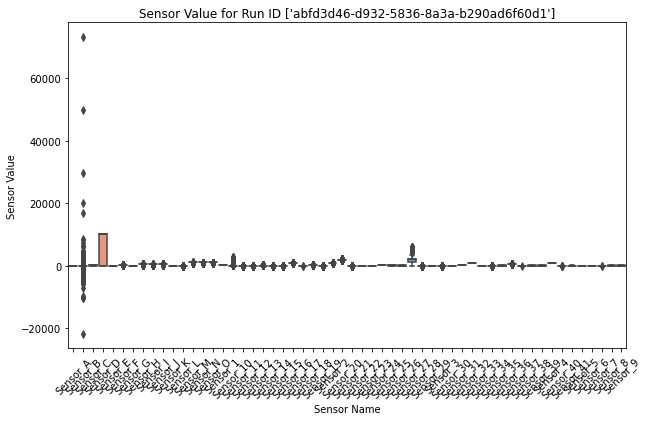

In [211]:
# Plot the graph
plt.figure(figsize=(10, 6))  # Adjust figure size
sns.boxplot(x='Sensor Name', y='Sensor Value', data=df_combined)
plt.xticks(rotation=45)
plt.title(f'Sensor Value for Run ID {random_run_ids}')

# Show the plot
plt.show()

In [ ]:
# for run in df_combined['Run ID'].unique():
#     subset_df = df_combined[df_combined['Run ID'] == run]  # Filter data for each Run ID

#     plt.figure(figsize=(8, 6))
#     sns.boxplot(x='Run type', y='Sensor Value', data = subset_df, showmeans=True, meanline=True)
#     plt.title(f"Scatter Plot for {run}")
#     plt.show()

In [212]:
for run in df_combined['Run ID'].unique():
    subset_df = df_combined[df_combined['Run ID'] == run]  # Filter data for each Run ID

    print(f'Stats for run {run}')
    print(subset_df.groupby('Run type')['Sensor Value'].mean())

Stats for run abfd3d46-d932-5836-8a3a-b290ad6f60d1
Run type
current_run     838.765930
incoming_run    244.478073
Name: Sensor Value, dtype: float32


In [213]:
from scipy.stats import spearmanr

# Separate values for each category
values_A = df_combined[df_combined['Run type'] == 'current_run']['Sensor Value']
values_B = df_combined[df_combined['Run type'] == 'incoming_run']['Sensor Value']

values_B2 = values_B.sample(len(values_A))

# Compute Spearman correlation
corr, p_value = spearmanr(values_A, values_B2)

print(f"Spearman correlation: {corr}, p-value: {p_value}")

Spearman correlation: -0.01522149726637279, p-value: 0.11598454046449619


In [214]:
meas_df.head()

Run ID      Run Start Time  \
0  00862337-2cc0-5b34-b5e1-45588e935c39 2024-01-02 04:45:25   
1  00862337-2cc0-5b34-b5e1-45588e935c39 2024-01-02 04:45:25   
2  00862337-2cc0-5b34-b5e1-45588e935c39 2024-01-02 04:45:25   
3  00862337-2cc0-5b34-b5e1-45588e935c39 2024-01-02 04:45:25   
4  00862337-2cc0-5b34-b5e1-45588e935c39 2024-01-02 04:45:25   

         Run End Time  X_index  Y_index           X          Y  Point Index  \
0 2024-01-02 04:58:00        1       23 -143.877551  -9.183673            3   
1 2024-01-02 04:58:00        1       29 -143.877551  27.551020           48   
2 2024-01-02 04:58:00        2       34 -137.755102  58.163265           43   
3 2024-01-02 04:58:00        3       14 -131.632653 -64.285714           20   
4 2024-01-02 04:58:00        5       39 -119.387755  88.775510            8   

   Measurement  
0    10.006534  
1    10.002181  
2    10.031223  
3    10.055888  
4    10.089505

In [215]:
print(meas_df.columns.tolist())

['Run ID', 'Run Start Time', 'Run End Time', 'X_index', 'Y_index', 'X', 'Y', 'Point Index', 'Measurement']


In [84]:
# Number of random run IDs you want to select
num_random_ids = 10

# Select random run IDs
random_meas_ids = meas_df['Run ID'].sample(n=num_random_ids, random_state=42).tolist()

print(random_meas_ids)

# Filter the DataFrame
filtered_meas_df = meas_df[meas_df['Run ID'].isin(random_meas_ids)]

['9502ed22-371d-5421-bce2-73a632c72458', '127f4965-bf6f-5af6-9734-c5d899b150fb', '596a199f-4477-5548-a342-552bdb00f2fe', 'a8574028-b241-5ebe-9ddd-79d469e575af', 'e63508c4-ca19-5d3e-8982-4b093babedce', '49249838-e75c-59d5-bd60-c77165c2fd6b', 'c99a9e54-9288-5470-ac72-aad6794e621b', '984f8f1c-4534-50ec-a9e8-e1354db4a10f', 'd987310e-2f57-5824-a21d-33d6b13d287e', '034077e6-dde6-5afa-9bed-a902194d24e5']


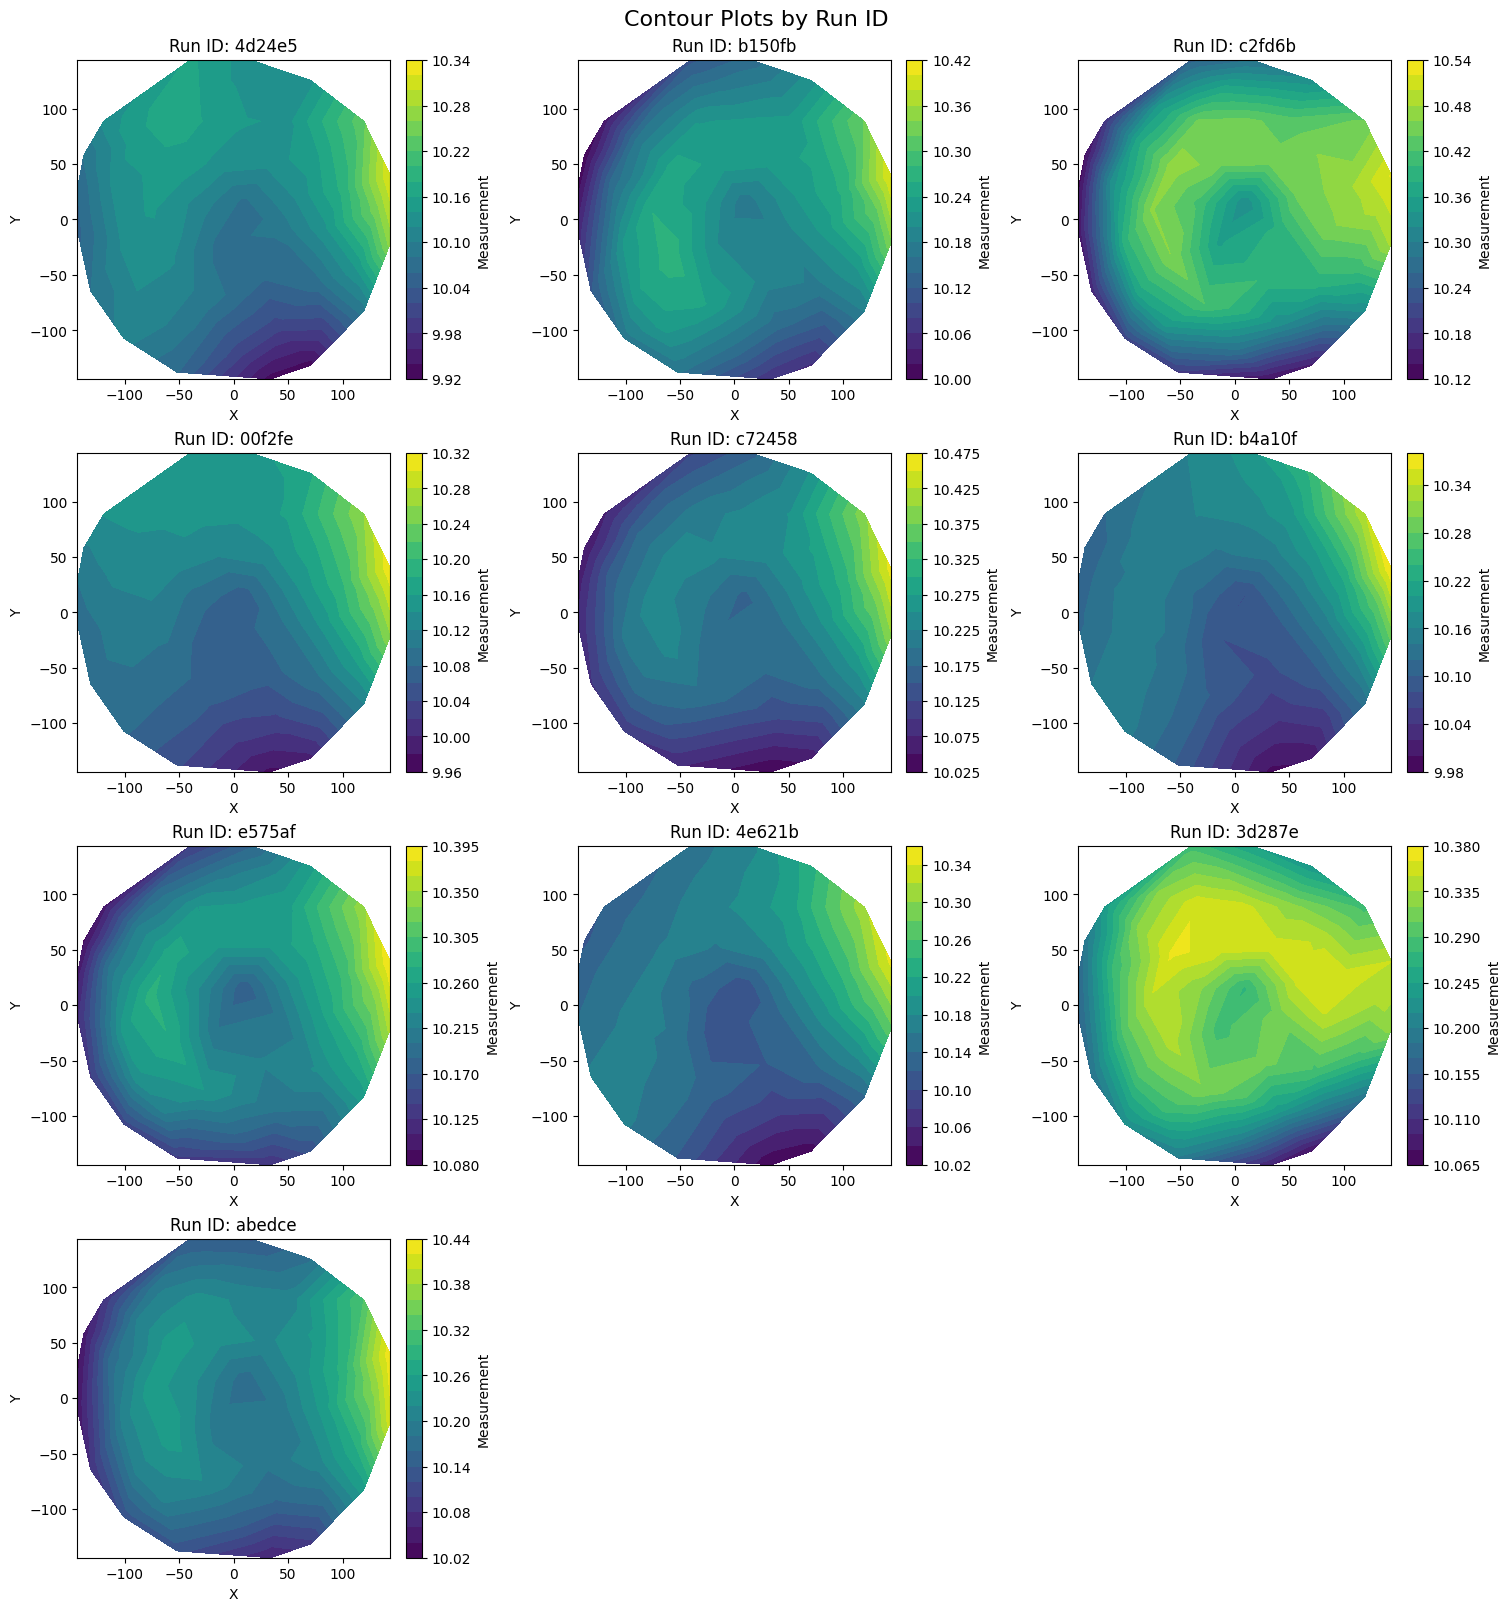

In [85]:
# # Loop through each unique Run ID and create a separate plot
# for run_id in filtered_meas_df['Run ID'].unique():
#     subset_df = meas_df[meas_df['Run ID'] == run_id]  # Filter data for each Run ID
    
#     plt.figure(figsize=(8, 6))
#     sns.scatterplot(x='X', y='Y', hue='Measurement', palette='coolwarm', data=subset_df)
#     plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.title(f"Scatter Plot for Run ID {run_id}")
#     plt.show()

# Get unique run IDs
run_ids = filtered_meas_df['Run ID'].unique()
n = len(run_ids)

# Determine subplot grid size (e.g., 2 rows, 3 columns for 5 plots)
cols = 3
rows = math.ceil(n / cols)

# Create figure and axes
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), constrained_layout=True)

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, run_id in enumerate(run_ids):
    ax = axes[i]
    subset_df = filtered_meas_df[filtered_meas_df['Run ID'] == run_id]

    x = subset_df['X'].values
    y = subset_df['Y'].values
    z = subset_df['Measurement'].values

    triang = tri.Triangulation(x, y)
    contour = ax.tricontourf(triang, z, levels=20, cmap='viridis')
    fig.colorbar(contour, ax=ax, label='Measurement')

    ax.set_title(f'Run ID: {run_id[-6:]}')  # Optional: show last few chars of ID
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Contour Plots by Run ID', fontsize=16)
plt.show()

In [220]:
# 2b. Tool-life feature: max ConsumableLife per run
life_feat = (
    run_df
      .groupby("Run ID")["Consumable Life"]
      .max()
      .rename("ConsumableLifeMax")
      .reset_index()
)

# merge features
meas_combined = meas_df.merge(life_feat, on="Run ID")

In [222]:
meas_combined.head()

Run ID      Run Start Time  \
0  00862337-2cc0-5b34-b5e1-45588e935c39 2024-01-02 04:45:25   
1  00862337-2cc0-5b34-b5e1-45588e935c39 2024-01-02 04:45:25   
2  00862337-2cc0-5b34-b5e1-45588e935c39 2024-01-02 04:45:25   
3  00862337-2cc0-5b34-b5e1-45588e935c39 2024-01-02 04:45:25   
4  00862337-2cc0-5b34-b5e1-45588e935c39 2024-01-02 04:45:25   

         Run End Time  X_index  Y_index           X          Y  Point Index  \
0 2024-01-02 04:58:00        1       23 -143.877551  -9.183673            3   
1 2024-01-02 04:58:00        1       29 -143.877551  27.551020           48   
2 2024-01-02 04:58:00        2       34 -137.755102  58.163265           43   
3 2024-01-02 04:58:00        3       14 -131.632653 -64.285714           20   
4 2024-01-02 04:58:00        5       39 -119.387755  88.775510            8   

   Measurement  ConsumableLifeMax  
0    10.006534          34.683315  
1    10.002181          34.683315  
2    10.031223          34.683315  
3    10.055888          34.683315  
4    10.089505          34.683315

In [223]:
# Number of random measurements you want to select
num_random_ids = 5

# Select random run IDs
random_point_ids = meas_combined['Point Index'].sample(n=num_random_ids, random_state=42).tolist()
print(random_point_ids)

# Filter the DataFrame
filtered_point_df = meas_combined[meas_combined['Point Index'].isin(random_point_ids)]

[31, 32, 14, 29, 44]


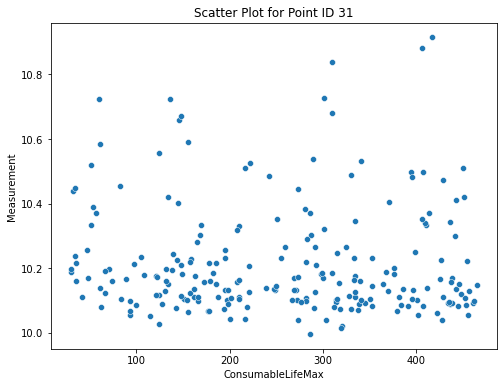

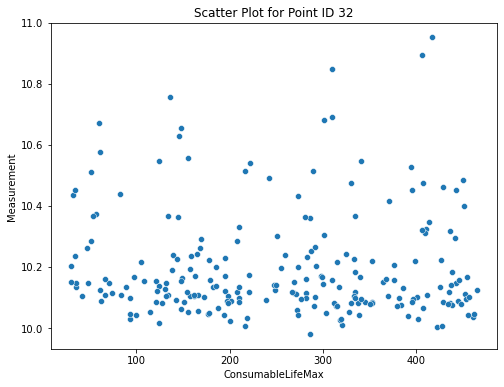

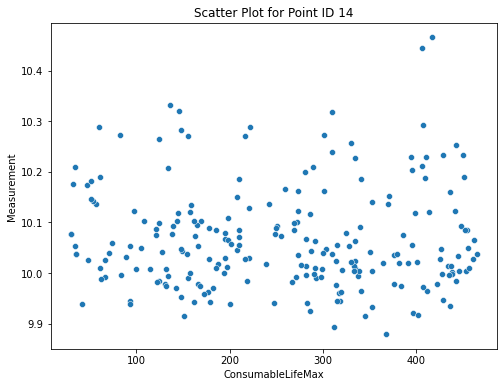

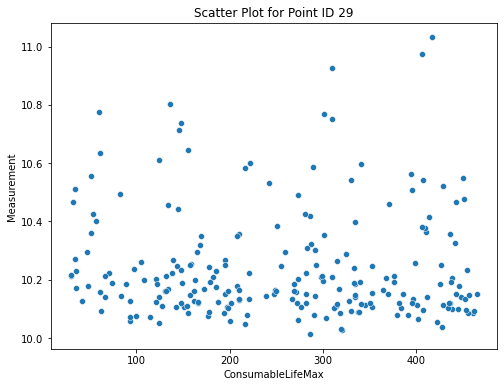

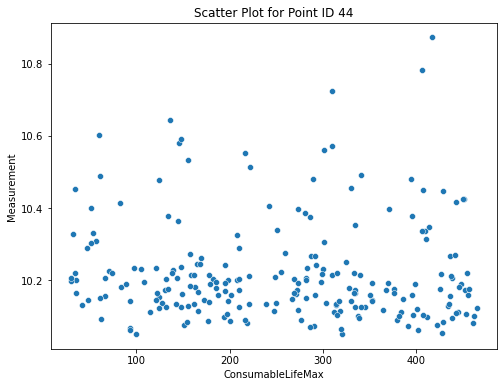

In [224]:
# # Plot the graph
# plt.figure(figsize=(8, 6))  # Adjust figure size
# sns.scatterplot(x='ConsumableLifeMax', y='Measurement', hue='Point Index', data=filtered_point_df)
# plt.xticks(rotation=45)
# plt.title(f'Measurement vs consumable life for Point {random_point_ids}')

# # Show the plot
# plt.show()

# Loop through each unique point
for id in random_point_ids:
    subset_df = filtered_point_df[filtered_point_df['Point Index'] == id]  # Filter data for each Run ID
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='ConsumableLifeMax', y='Measurement', data=subset_df)
    plt.title(f"Scatter Plot for Point ID {id}")
    plt.show()


In [227]:
    # corr_matrix = subset_df.corr(numeric_only=True)["Measurement"].sort_values(ascending=False)
    # print(corr_matrix)

correlations = meas_combined.groupby('Point Index')['ConsumableLifeMax'].corr(meas_combined["Measurement"]).sort_values

print(correlations)

<bound method Series.sort_values of Point Index
0    -0.009055
1    -0.040203
2    -0.020581
3     0.007541
4    -0.037709
5    -0.023502
6    -0.035239
7     0.043954
8    -0.022710
9    -0.036384
10   -0.022608
11   -0.046031
12   -0.037902
13   -0.028138
14   -0.017190
15   -0.025533
16   -0.023285
17    0.036373
18   -0.037930
19   -0.033956
20    0.029351
21   -0.026178
22   -0.027304
23   -0.041361
24   -0.021352
25   -0.029871
26   -0.038781
27   -0.019477
28   -0.034217
29   -0.043743
30   -0.017456
31   -0.045637
32   -0.030064
33   -0.030192
34   -0.020666
35   -0.042461
36   -0.043892
37   -0.001107
38   -0.008150
39   -0.019050
40   -0.018110
41   -0.042124
42   -0.027298
43   -0.012190
44   -0.040672
45   -0.024593
46   -0.016709
47   -0.034324
48   -0.003605
Name: ConsumableLifeMax, dtype: float64>


In [40]:
agg_df = run_df.groupby(['Run ID', 'Sensor Name'])['Sensor Value'].mean().reset_index()


In [41]:
from scipy.stats import zscore

agg_df['z_score'] = zscore(agg_df['Sensor Value'])


In [ ]:
threshold = 3
outlier_runs = agg_df[np.abs(agg_df['z_score']) > threshold]['Run ID']

In [51]:
clean_run_df = run_df[~run_df['Run ID'].isin(outlier_runs)]


In [52]:
sensor_agg = clean_run_df.groupby('Run ID')['Sensor Value'].mean().reset_index()
merged_df = meas_df.merge(sensor_agg, on='Run ID', how='left')

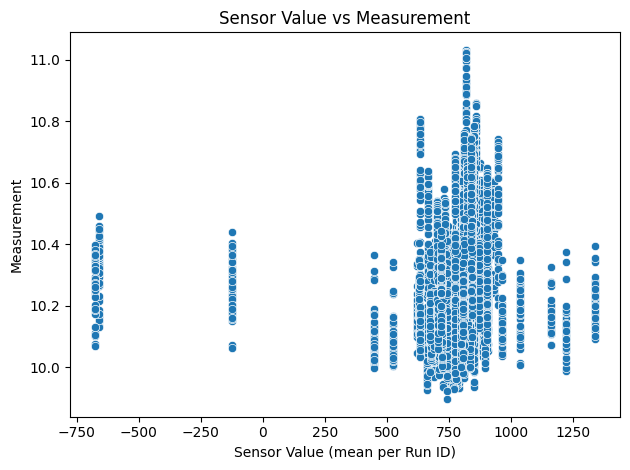

In [53]:

sns.scatterplot(data=merged_df, x='Sensor Value', y='Measurement')
plt.title('Sensor Value vs Measurement')
plt.xlabel('Sensor Value (mean per Run ID)')
plt.ylabel('Measurement')
plt.tight_layout()
plt.show()